<img src="https://th.bing.com/th/id/OIP.dz0FONFec0OeahwY-zRiAQAAAA?pid=ImgDet&rs=1" alt="Alternative text" />

## 1. Project Overview

### 1-1. Project Details
In this project machining data was collected from a CNC machine for variations of tool condition, feed rate, and clamping pressure.
In 18 machining experiments, time series data was collected with a sampling rate of 100 ms from the 4 motors in the CNC (X, Y, Z axes and spindle).

### 1-2. Goals
The main goal of the project is to find the best model to predict the machine failure.

### 1-3. Import libraries

In [4]:
# loading dataset and math
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Pipeline and Column
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# data preprocessing
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
from feature_engine.outliers import Winsorizer

# Missing Data Imputation
from feature_engine.imputation import ArbitraryNumberImputer, EndTailImputer, RandomSampleImputer
from sklearn.impute import SimpleImputer, KNNImputer

# feature magnitude
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# metrics
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score, 
    confusion_matrix,
    recall_score, 
    f1_score,
    precision_score,
    recall_score
)

# Machine Learning Models
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Supress warnings
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

## 2. Dataset collecting

In [5]:
main_df = pd.read_csv('data/input_TP/train.csv')
main_df.head(10)

,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,1,wax,6,4.0,unworn,yes,yes
1,2,wax,20,4.0,unworn,yes,yes
2,3,wax,6,3.0,unworn,yes,yes
3,4,wax,6,2.5,unworn,no,NaN
4,5,wax,20,3.0,unworn,no,NaN
5,6,wax,6,4.0,worn,yes,no
6,7,wax,20,4.0,worn,no,NaN
7,8,wax,20,4.0,worn,yes,no
8,9,wax,15,4.0,worn,yes,no
9,10,wax,12,4.0,worn,yes,no


In [6]:
files = list()
for i in range(1, 19):
    exp_number = '0' + str(i) if i < 10 else  str(i)
    
    file = pd.read_csv('data/input_TP/experiment_{}.csv'.format(exp_number))
    
    row = main_df[main_df['No'] == i]
    file['feedrate'] = row.iloc[0]['feedrate']
    file['clamp_pressure'] = row.iloc[0]['clamp_pressure']
    # Encoding target variable
    file['label'] = 1 if row.iloc[0]['tool_condition'] == 'worn' else 0
    files.append(file)

cnc_df = pd.concat(files, ignore_index = True)
cnc_df.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandPosition,Y1_CommandVelocity,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandPosition,Z1_CommandVelocity,Z1_CommandAcceleration,Z1_CurrentFeedback,Z1_DCBusVoltage,Z1_OutputCurrent,Z1_OutputVoltage,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,feedrate,clamp_pressure,label
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,-0.000001,158.0,-0.025,-6.25,158.0,0.0,0.000000,0.539,0.0167,328.0,1.84,6.430000e-07,119.0,0.0,0.00,119.0,0.0,0.000000,0.0,0.0,0.0,0.0,-361.0,0.001,0.250,-361.0,0.0,0.0,0.524,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,Starting,6,4.0,0
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,0.004480,158.0,-19.800,-750.00,157.0,-24.6,-647.000000,-14.500,0.2810,325.0,37.80,1.260000e-02,119.0,-20.3,-712.00,118.0,-25.6,-674.000000,0.0,0.0,0.0,0.0,-361.0,0.000,0.250,-361.0,0.0,0.0,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,Prep,6,4.0,0
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,0.005330,154.0,-32.500,0.00,154.0,-32.3,-0.000095,-7.790,0.1390,327.0,49.40,9.430000e-03,115.0,-33.7,37.50,115.0,-33.7,-0.000095,0.0,0.0,0.0,0.0,-361.0,0.000,-0.438,-361.0,0.0,0.0,0.524,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,Prep,6,4.0,0
3,194.0,-18.0,0.00,194.0,-17.9,-0.000095,-6.11,0.1300,327.0,30.30,0.004890,151.0,-32.600,-62.50,NaN,-32.3,-0.000095,-8.130,0.1560,325.0,47.60,1.050000e-02,112.0,-33.7,-6.25,112.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,-0.001,-0.250,-361.0,0.0,0.0,-0.180,2.740000e-19,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,Prep,6,4.0,0
4,193.0,-17.9,-18.80,192.0,-17.9,0.000095,-5.70,0.1140,328.0,30.50,0.004250,148.0,-32.000,138.00,148.0,-32.3,0.000095,-13.800,0.2020,326.0,47.10,1.350000e-02,109.0,-33.6,18.80,108.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,0.000,-0.188,-361.0,0.0,0.0,0.226,2.740000e-19,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,Prep,6,4.0,0


In [7]:
# Encoding Machining Process feature using map function
data = [cnc_df]

pro = {
    'Layer 1 Up': 1,
    'Repositioning': 2,
    'Layer 2 Up': 3,
    'Layer 2 Up': 4,
    'Layer 1 Down': 5,
    'End': 6,
    'Layer 2 Down': 7,
    'Layer 3 Down': 8,
    'Prep': 9,
    'end': 10,
    'Starting': 11
}

for dataset in data:
    dataset['Machining_Process'] = dataset['Machining_Process'].map(pro)

In [8]:
cnc_df.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandPosition,Y1_CommandVelocity,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandPosition,Z1_CommandVelocity,Z1_CommandAcceleration,Z1_CurrentFeedback,Z1_DCBusVoltage,Z1_OutputCurrent,Z1_OutputVoltage,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,feedrate,clamp_pressure,label
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,-0.000001,158.0,-0.025,-6.25,158.0,0.0,0.000000,0.539,0.0167,328.0,1.84,6.430000e-07,119.0,0.0,0.00,119.0,0.0,0.000000,0.0,0.0,0.0,0.0,-361.0,0.001,0.250,-361.0,0.0,0.0,0.524,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,11.0,6,4.0,0
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,0.004480,158.0,-19.800,-750.00,157.0,-24.6,-647.000000,-14.500,0.2810,325.0,37.80,1.260000e-02,119.0,-20.3,-712.00,118.0,-25.6,-674.000000,0.0,0.0,0.0,0.0,-361.0,0.000,0.250,-361.0,0.0,0.0,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,9.0,6,4.0,0
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,0.005330,154.0,-32.500,0.00,154.0,-32.3,-0.000095,-7.790,0.1390,327.0,49.40,9.430000e-03,115.0,-33.7,37.50,115.0,-33.7,-0.000095,0.0,0.0,0.0,0.0,-361.0,0.000,-0.438,-361.0,0.0,0.0,0.524,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,9.0,6,4.0,0
3,194.0,-18.0,0.00,194.0,-17.9,-0.000095,-6.11,0.1300,327.0,30.30,0.004890,151.0,-32.600,-62.50,NaN,-32.3,-0.000095,-8.130,0.1560,325.0,47.60,1.050000e-02,112.0,-33.7,-6.25,112.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,-0.001,-0.250,-361.0,0.0,0.0,-0.180,2.740000e-19,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,9.0,6,4.0,0
4,193.0,-17.9,-18.80,192.0,-17.9,0.000095,-5.70,0.1140,328.0,30.50,0.004250,148.0,-32.000,138.00,148.0,-32.3,0.000095,-13.800,0.2020,326.0,47.10,1.350000e-02,109.0,-33.6,18.80,108.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,0.000,-0.188,-361.0,0.0,0.0,0.226,2.740000e-19,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,9.0,6,4.0,0


## 3. Data analysis

In [9]:
# Function to plot distribution, probability plot and box-plot of the feature
def diagnostic_plots(df, variable):
    fig = plt.figure()
    plt.figure(figsize = (18, 5))
   
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], label = 'Skewness: %.2f'%(df[variable].skew()))
    plt.legend(loc = 'best')

    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist = 'norm', plot = plt)
    
    plt.subplot(1, 3, 3)
    fig = df.boxplot(column = variable)
    fig.set_title('Box-plot')
    fig.set_ylabel(variable)

    plt.show()

In [10]:
cnc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25286 entries, 0 to 25285
Data columns (total 51 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X1_ActualPosition          25284 non-null  float64
 1   X1_ActualVelocity          25278 non-null  float64
 2   X1_ActualAcceleration      25273 non-null  float64
 3   X1_CommandPosition         25247 non-null  float64
 4   X1_CommandVelocity         25250 non-null  float64
 5   X1_CommandAcceleration     25260 non-null  float64
 6   X1_CurrentFeedback         25254 non-null  float64
 7   X1_DCBusVoltage            25257 non-null  float64
 8   X1_OutputCurrent           25260 non-null  float64
 9   X1_OutputVoltage           25255 non-null  float64
 10  X1_OutputPower             25258 non-null  float64
 11  Y1_ActualPosition          25249 non-null  float64
 12  Y1_ActualVelocity          25256 non-null  float64
 13  Y1_ActualAcceleration      25243 non-null  flo

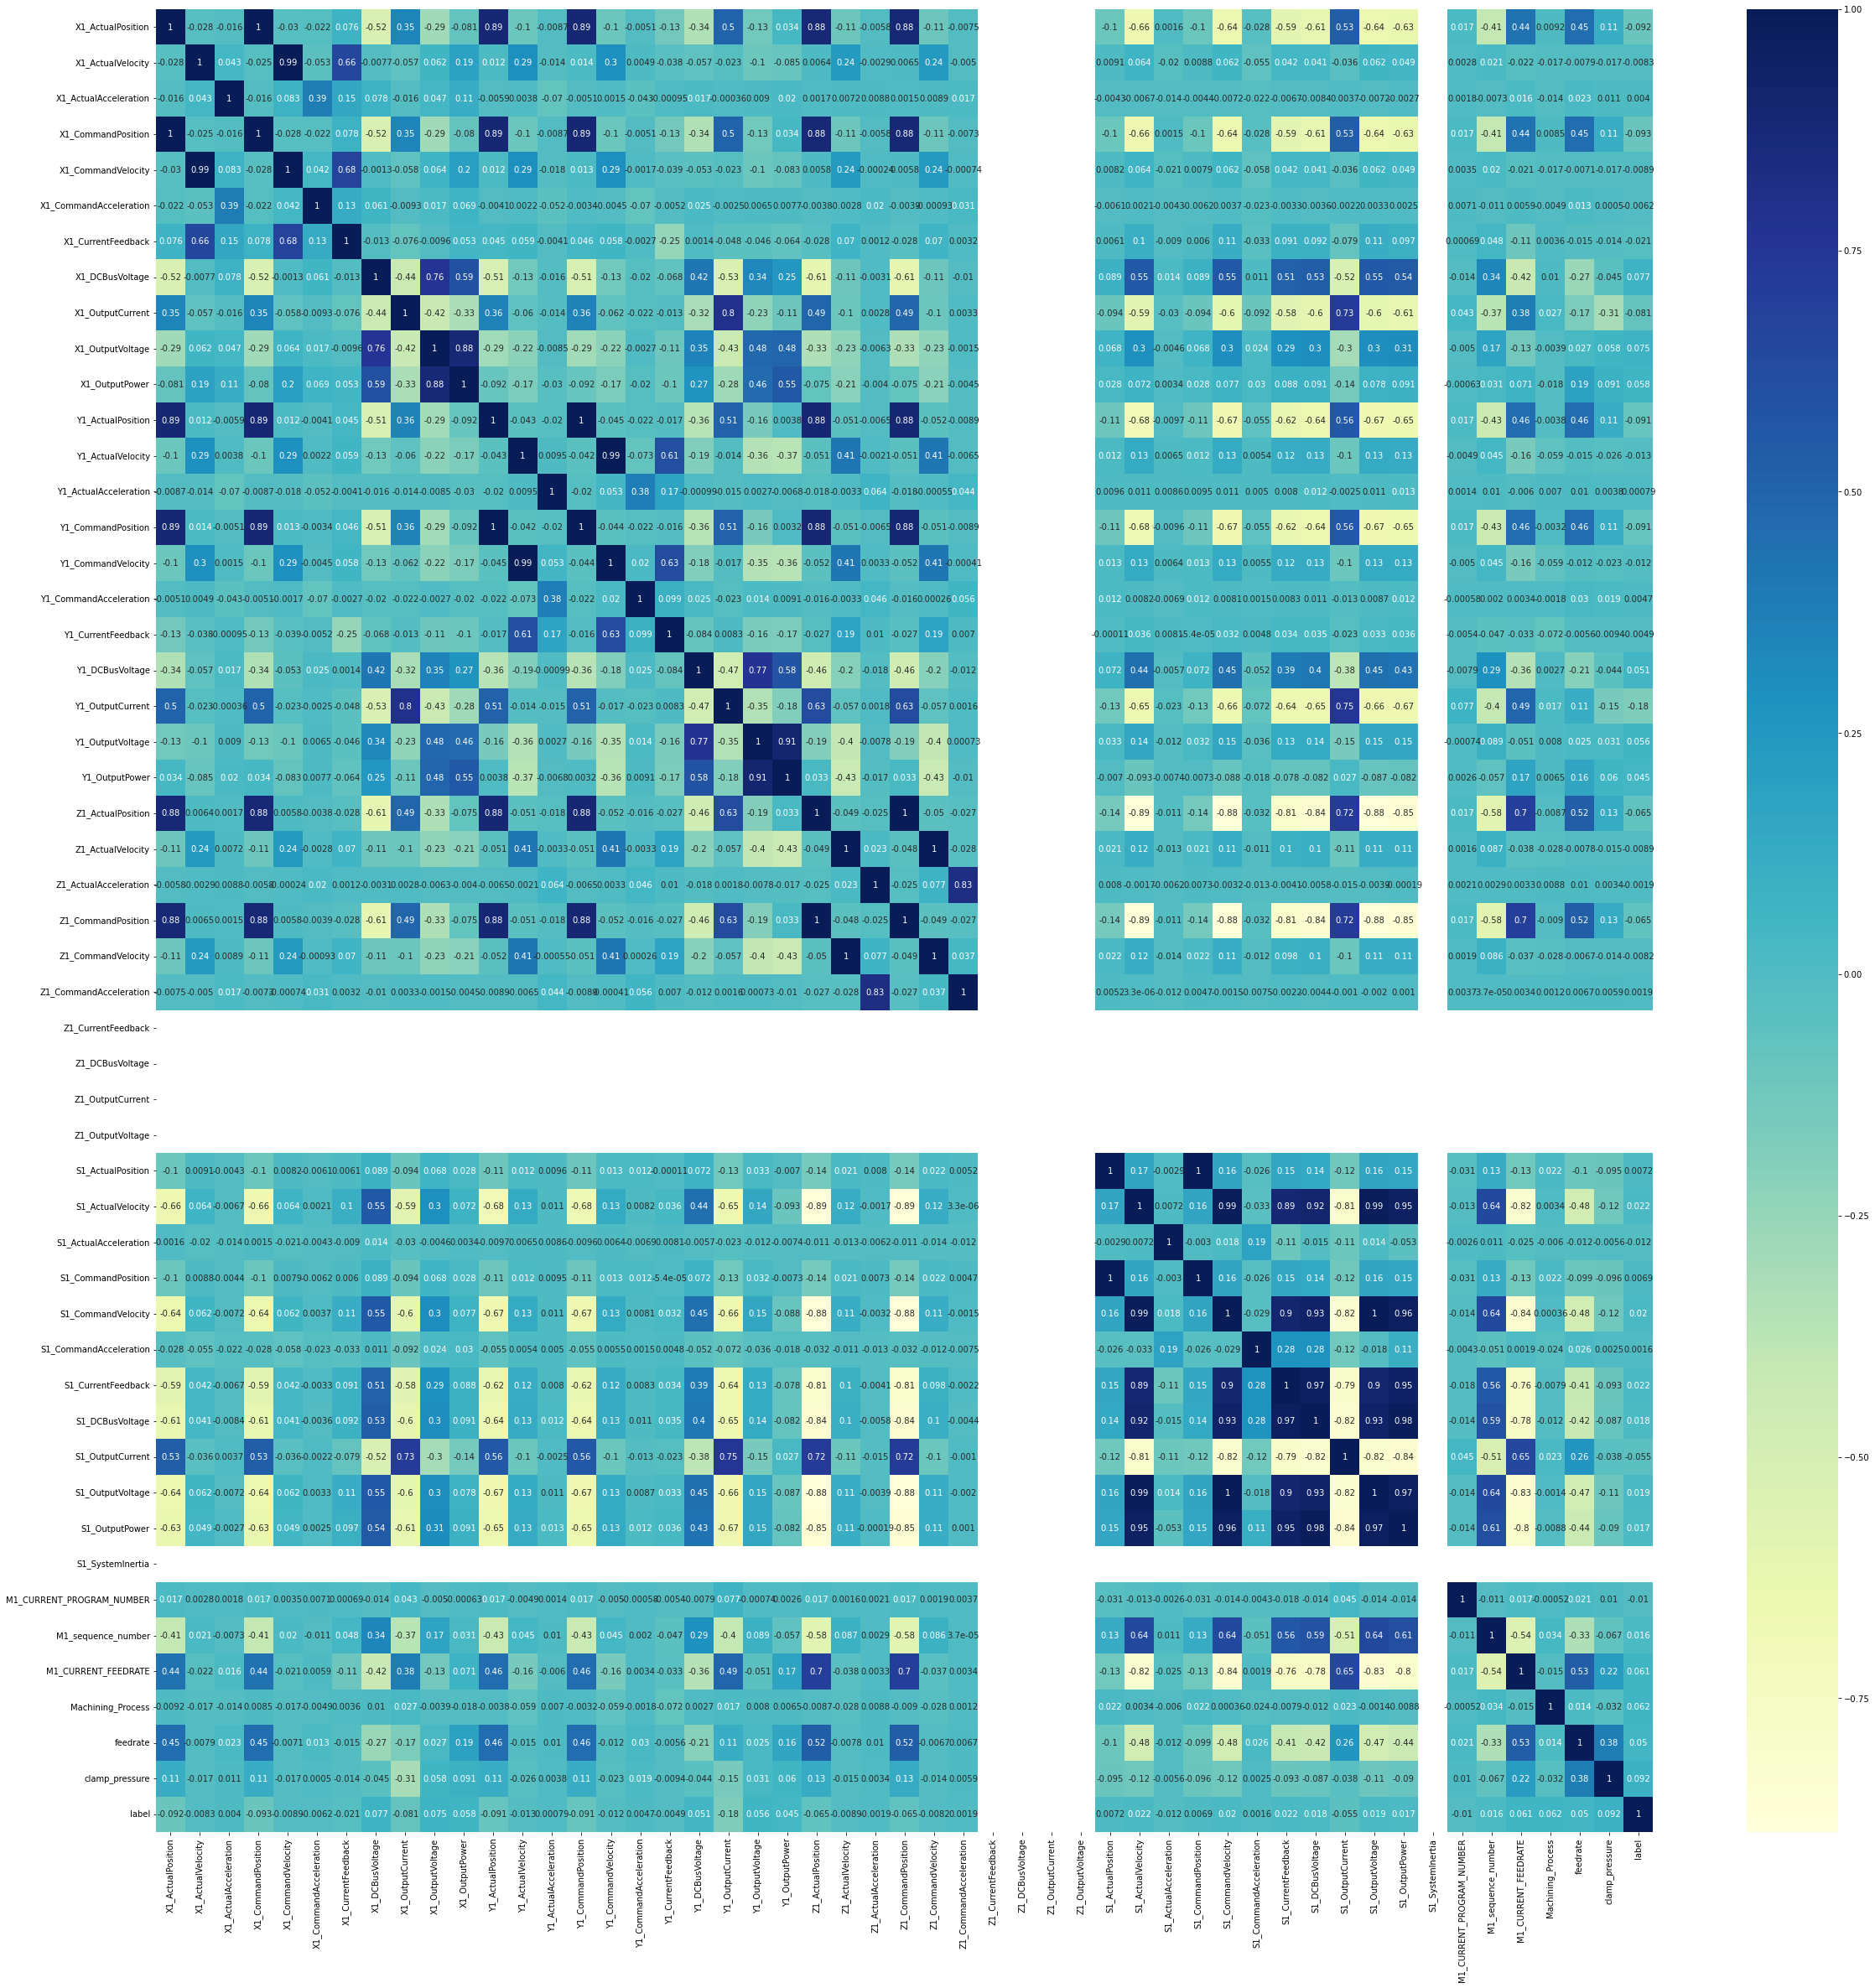

In [12]:
#correlation matrix

fig, ax = plt.subplots(figsize=(40,40)) 
sns.heatmap(cnc_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

Using correlation matrix we found a lot of correlated features. We going to handle them during data preprocessing.

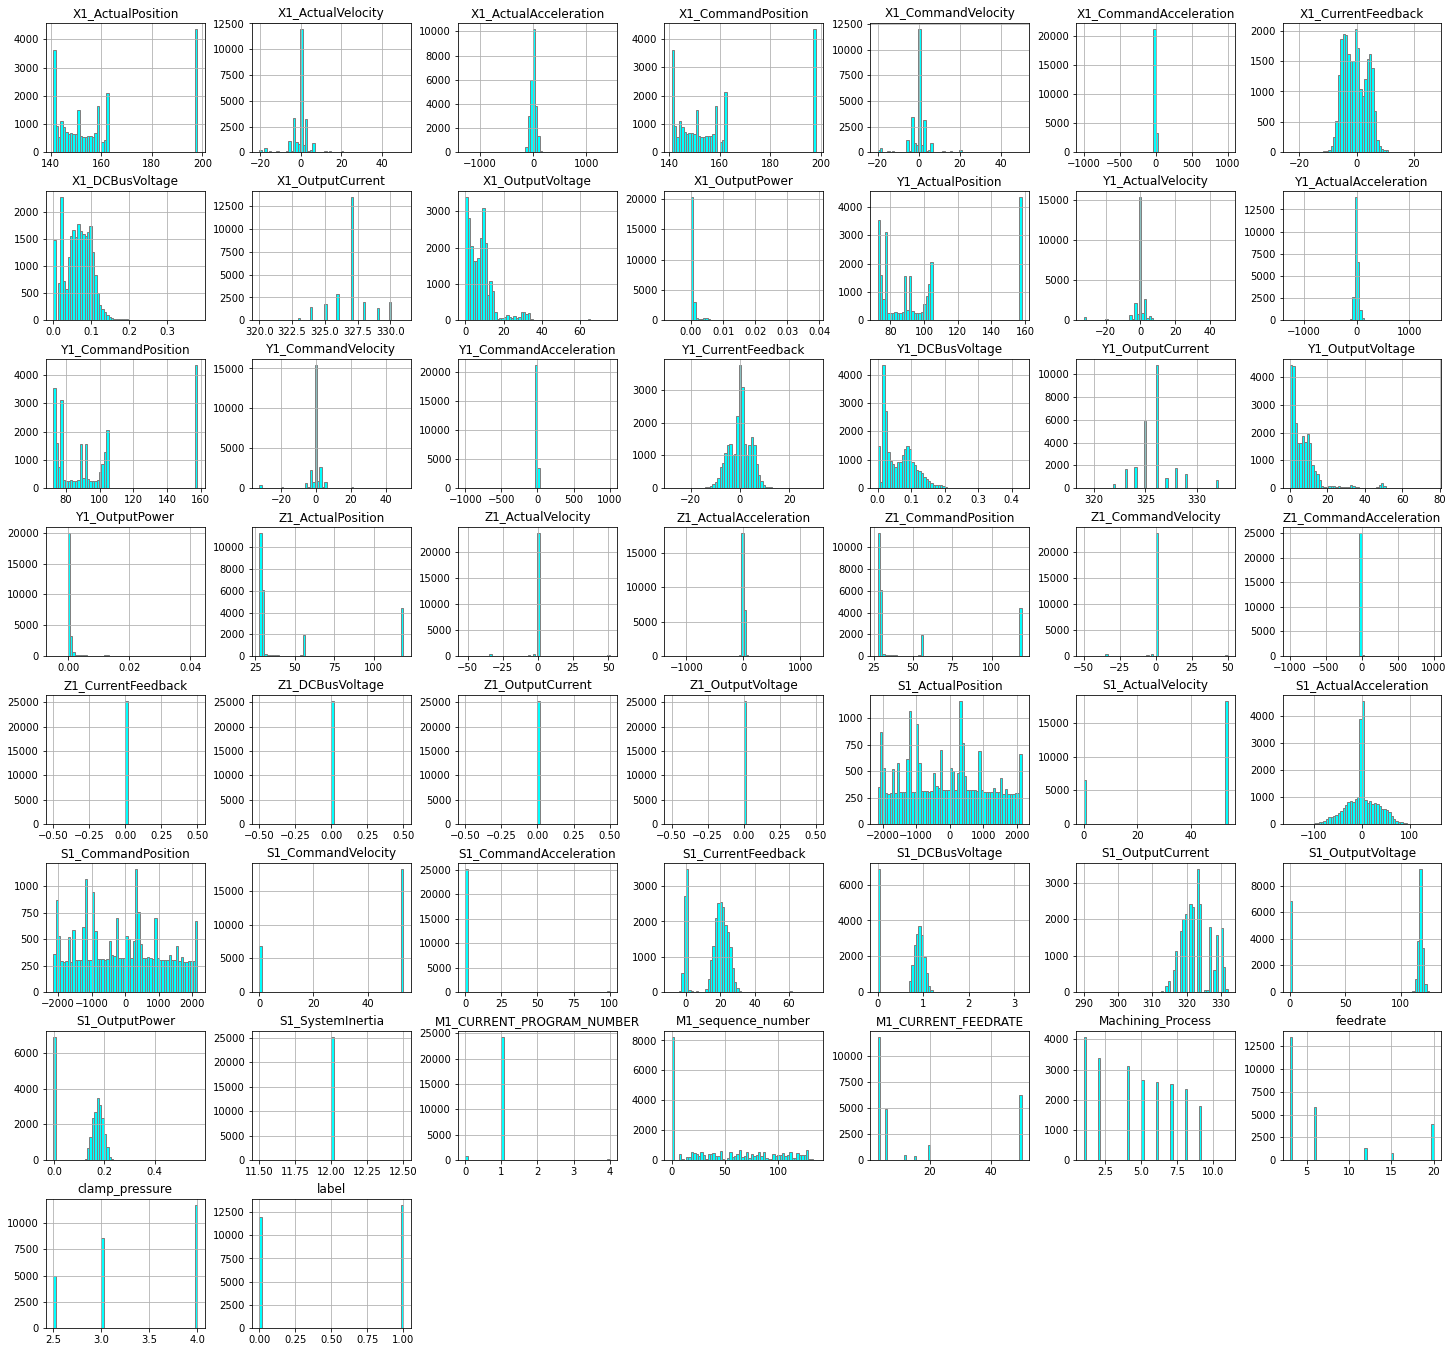

In [9]:
# Features distribution
fig_ = cnc_df.hist(figsize=(25, 24), bins=60, color="cyan",
                         edgecolor="gray", xlabelsize=10, ylabelsize=10)

As you can see, there is a lot of features with skewed distribution. Let's take a look at the distribution again using different kind of plots.

<Figure size 432x288 with 0 Axes>

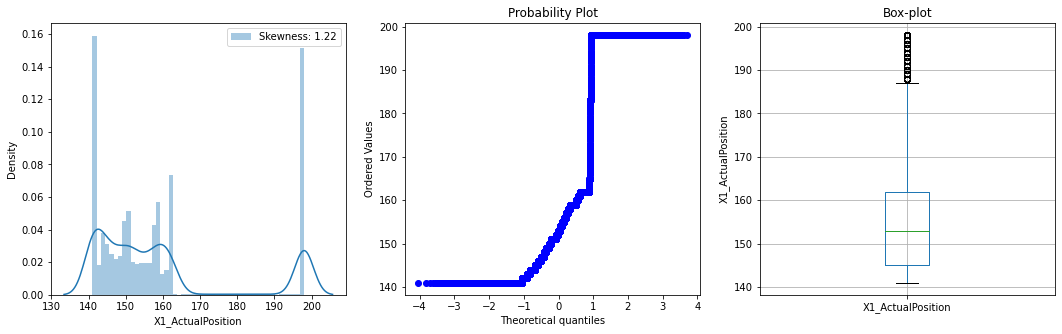

<Figure size 432x288 with 0 Axes>

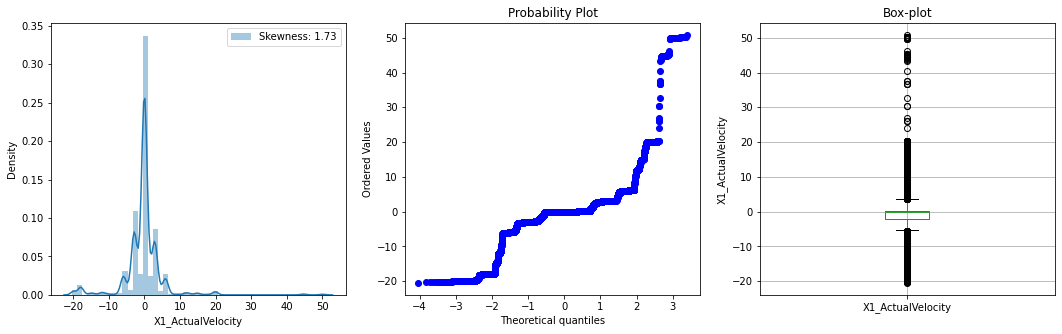

<Figure size 432x288 with 0 Axes>

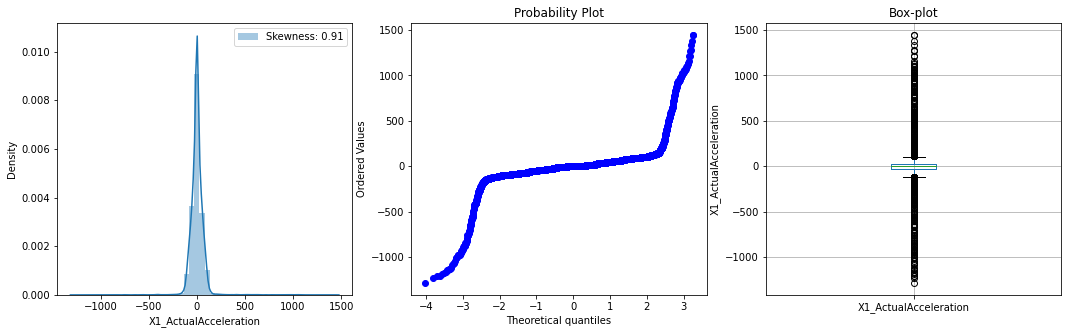

<Figure size 432x288 with 0 Axes>

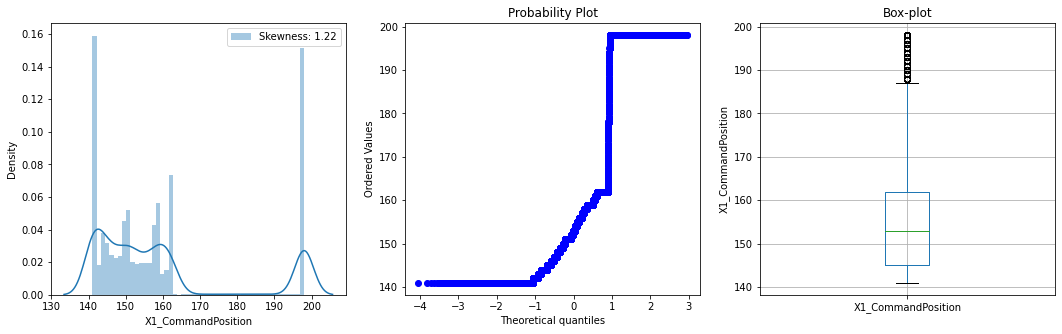

<Figure size 432x288 with 0 Axes>

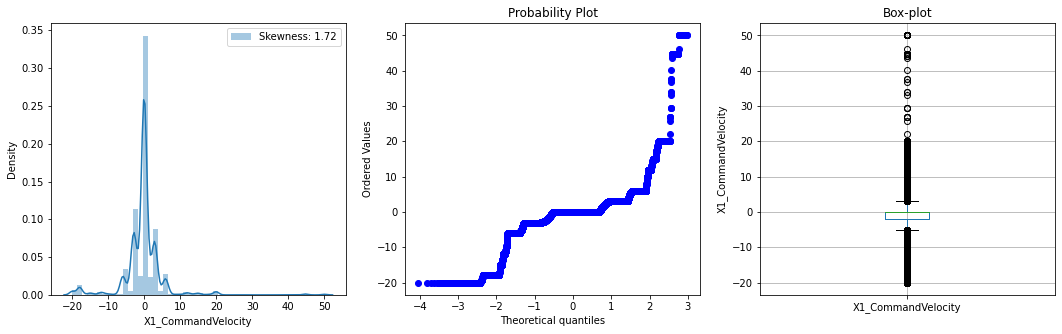

<Figure size 432x288 with 0 Axes>

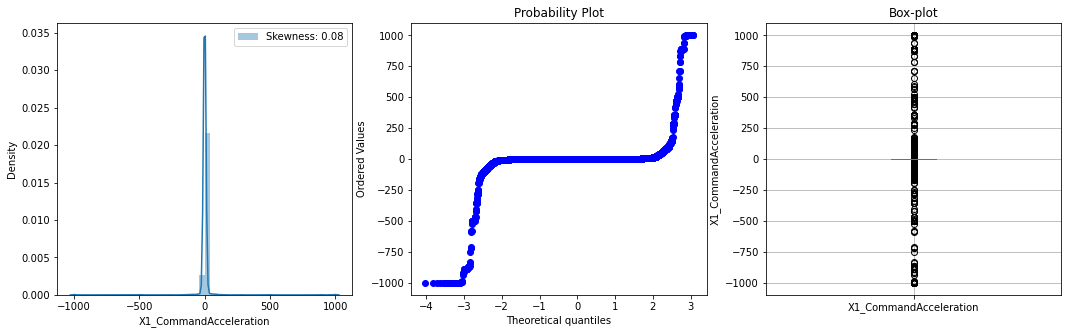

<Figure size 432x288 with 0 Axes>

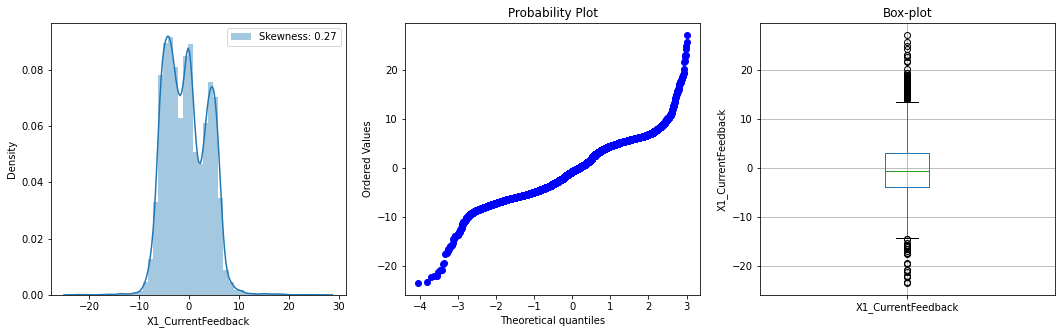

<Figure size 432x288 with 0 Axes>

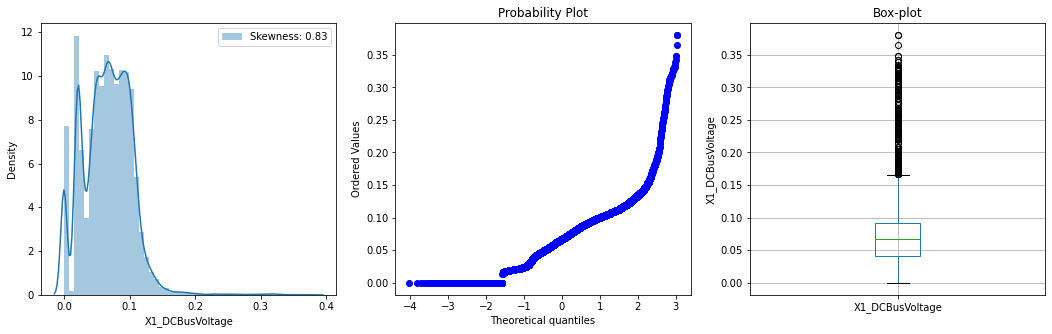

<Figure size 432x288 with 0 Axes>

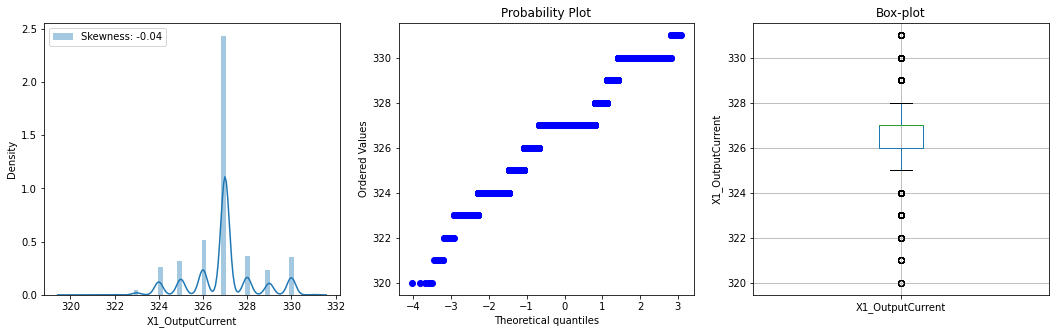

<Figure size 432x288 with 0 Axes>

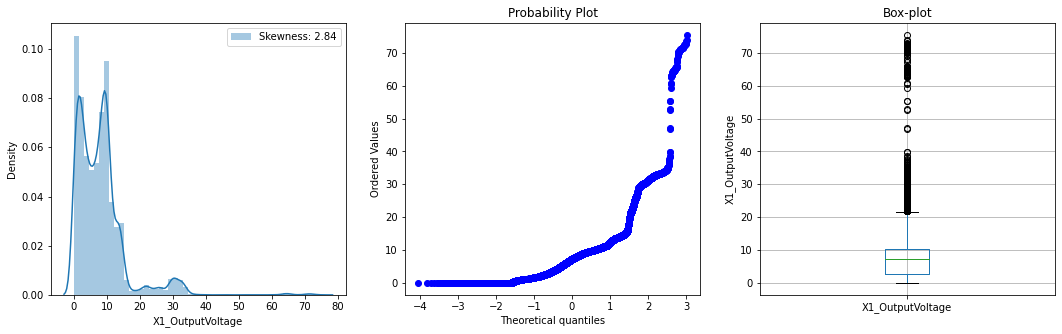

<Figure size 432x288 with 0 Axes>

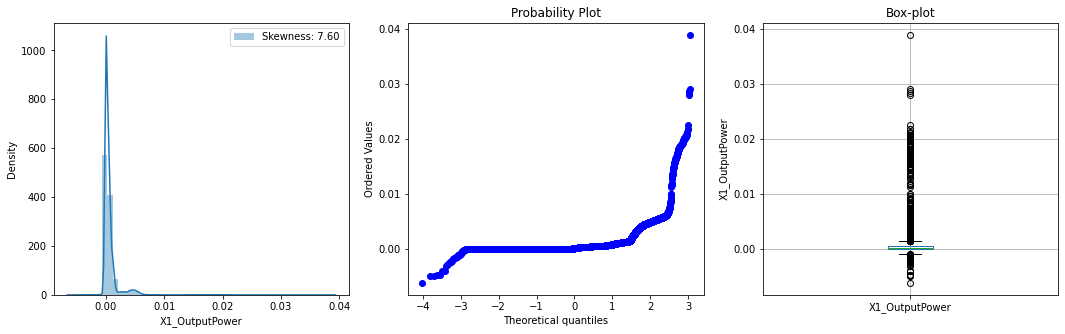

In [10]:
for var in cnc_df.columns:
    if 'X1' in var:
        diagnostic_plots(cnc_df, var)

<Figure size 432x288 with 0 Axes>

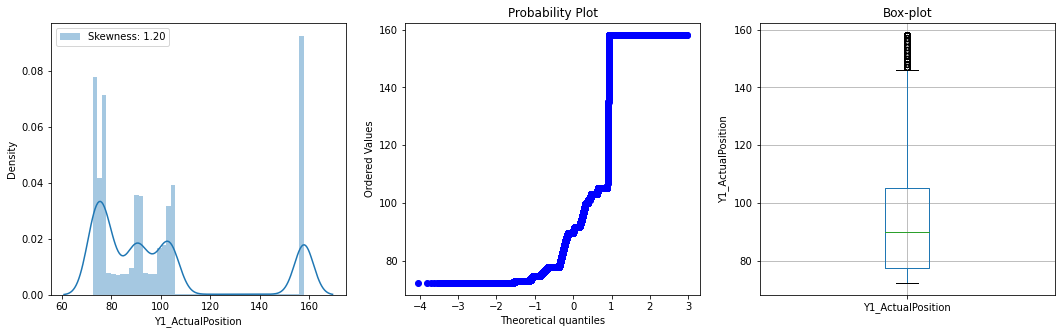

<Figure size 432x288 with 0 Axes>

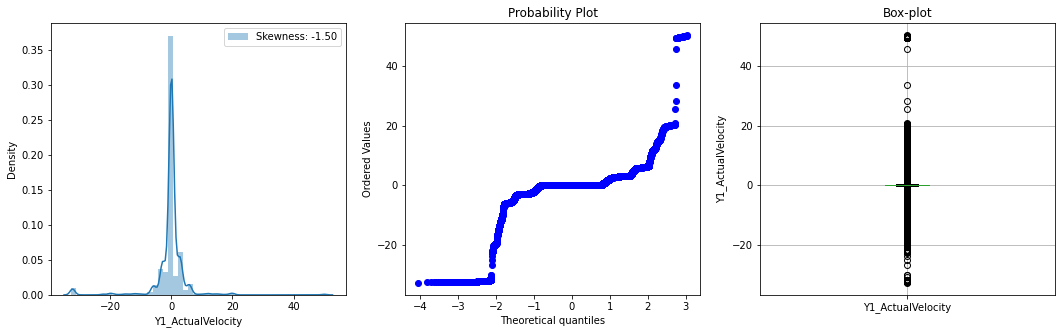

<Figure size 432x288 with 0 Axes>

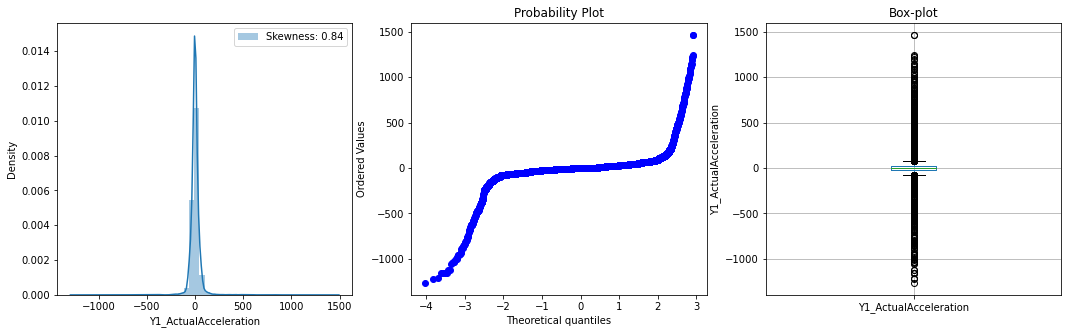

<Figure size 432x288 with 0 Axes>

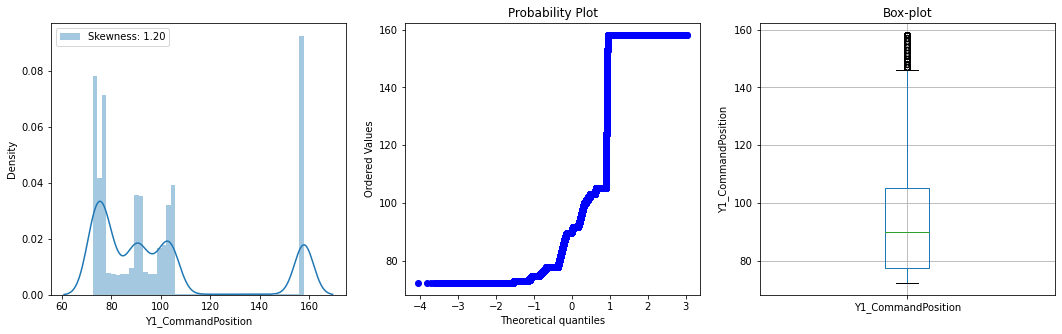

<Figure size 432x288 with 0 Axes>

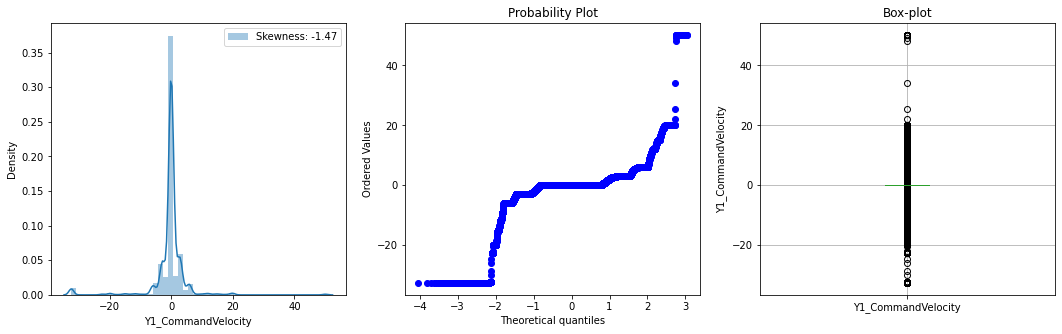

<Figure size 432x288 with 0 Axes>

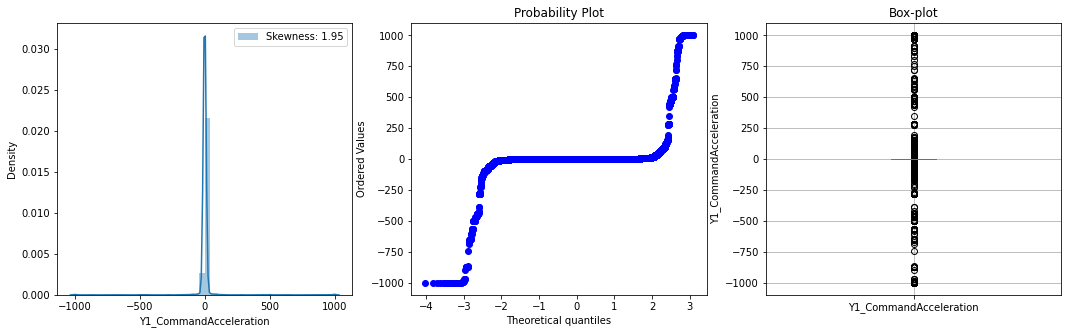

<Figure size 432x288 with 0 Axes>

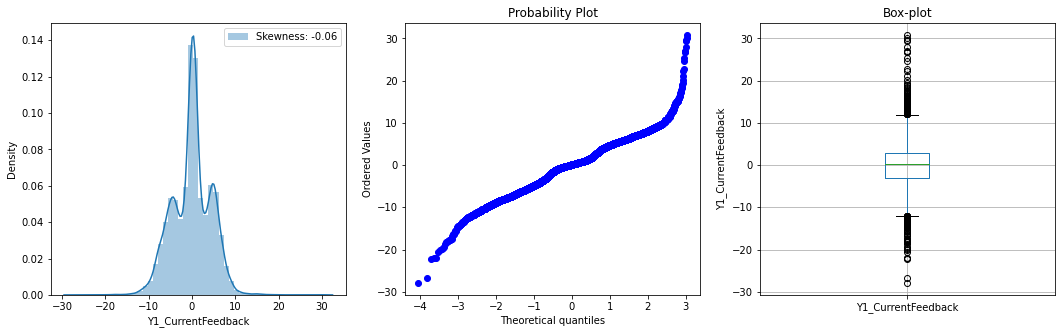

<Figure size 432x288 with 0 Axes>

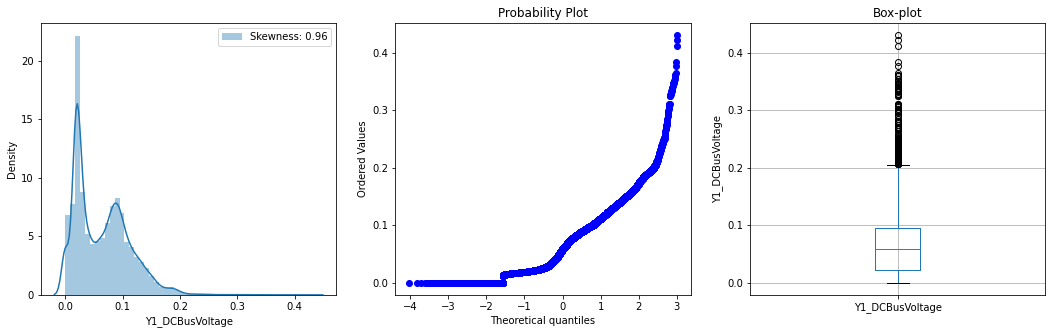

<Figure size 432x288 with 0 Axes>

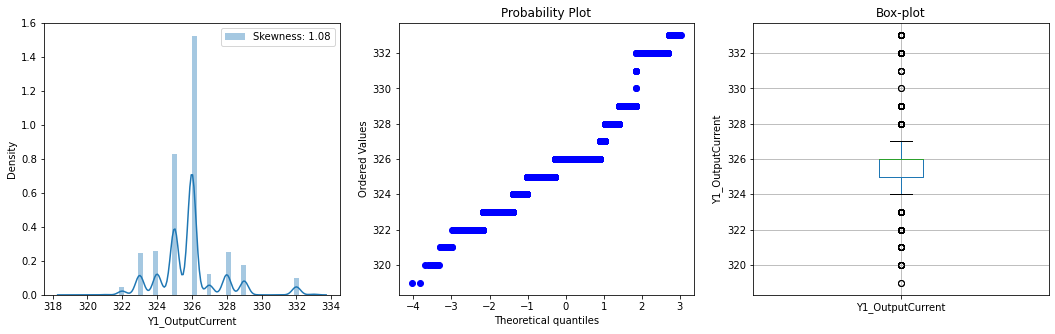

<Figure size 432x288 with 0 Axes>

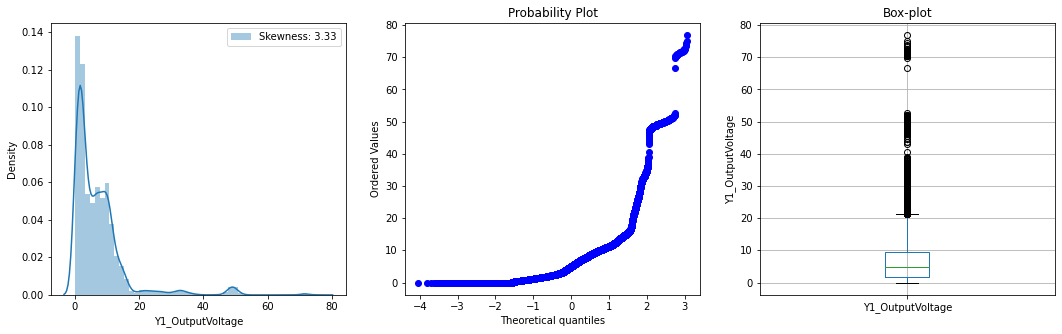

<Figure size 432x288 with 0 Axes>

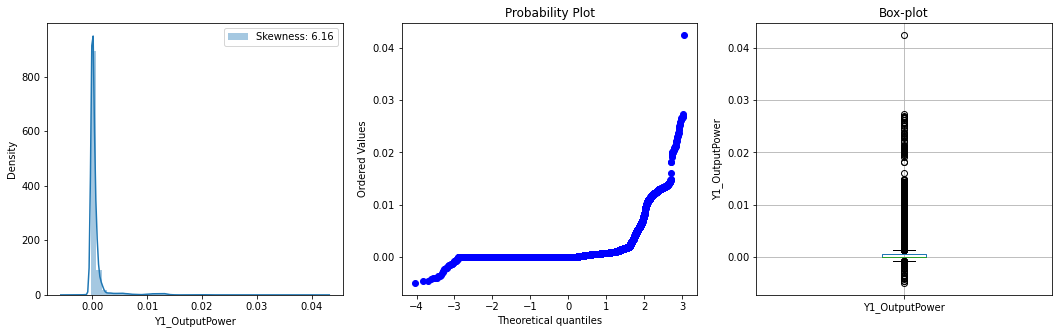

In [11]:
for var in cnc_df.columns:
    if 'Y1' in var:
        diagnostic_plots(cnc_df, var)

<Figure size 432x288 with 0 Axes>

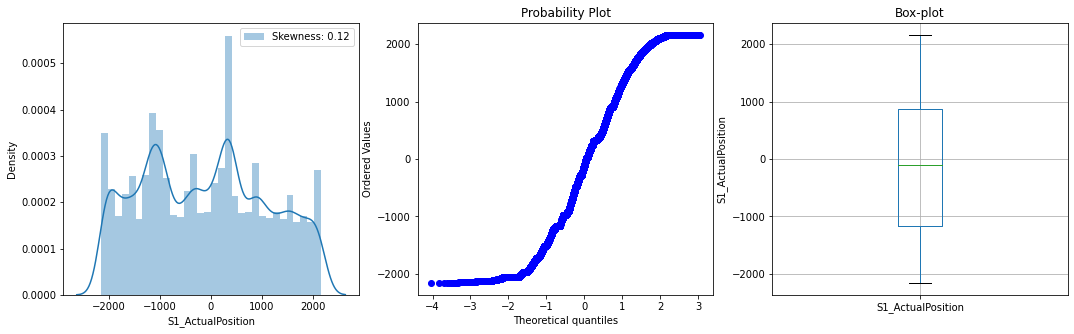

<Figure size 432x288 with 0 Axes>

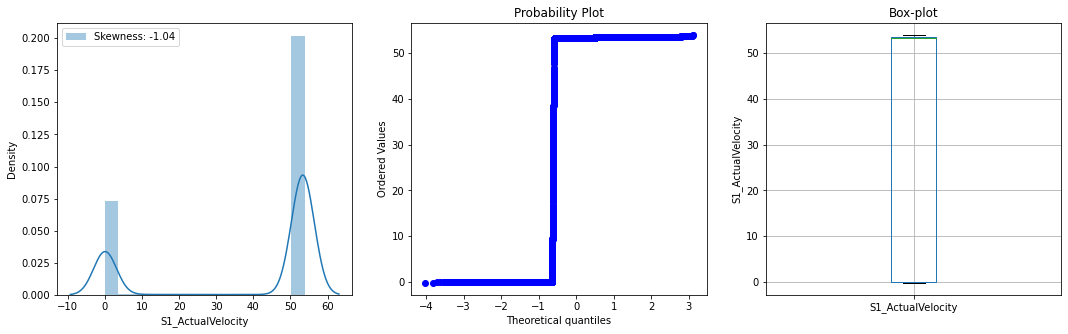

<Figure size 432x288 with 0 Axes>

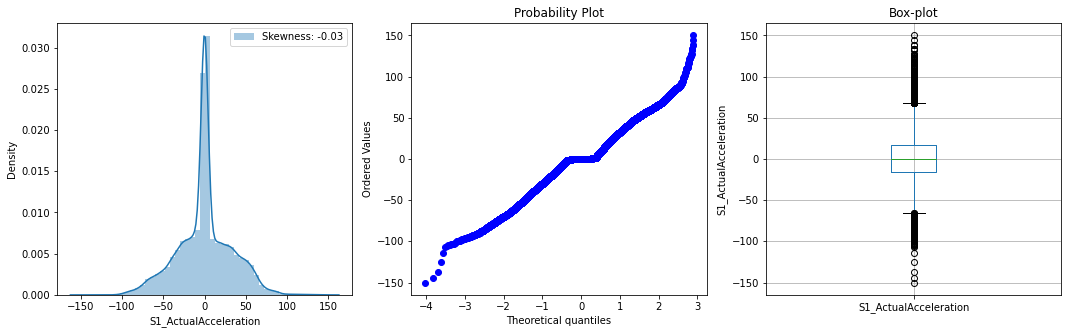

<Figure size 432x288 with 0 Axes>

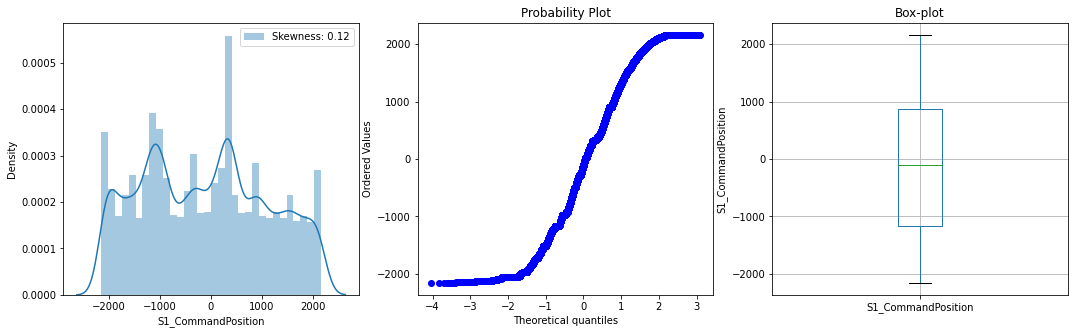

<Figure size 432x288 with 0 Axes>

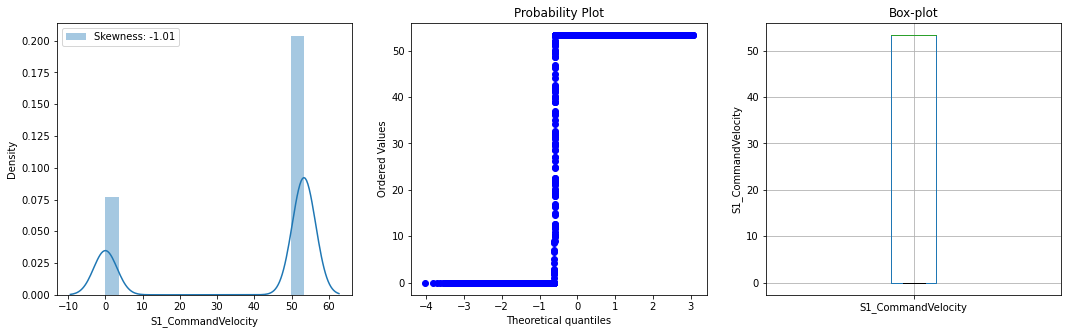

<Figure size 432x288 with 0 Axes>

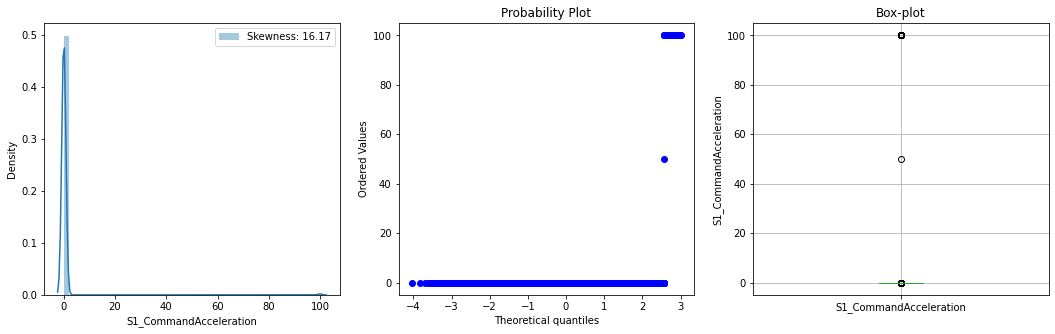

<Figure size 432x288 with 0 Axes>

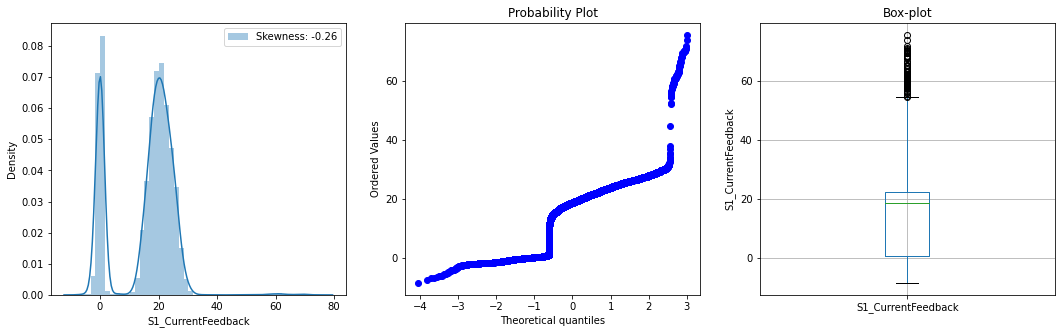

<Figure size 432x288 with 0 Axes>

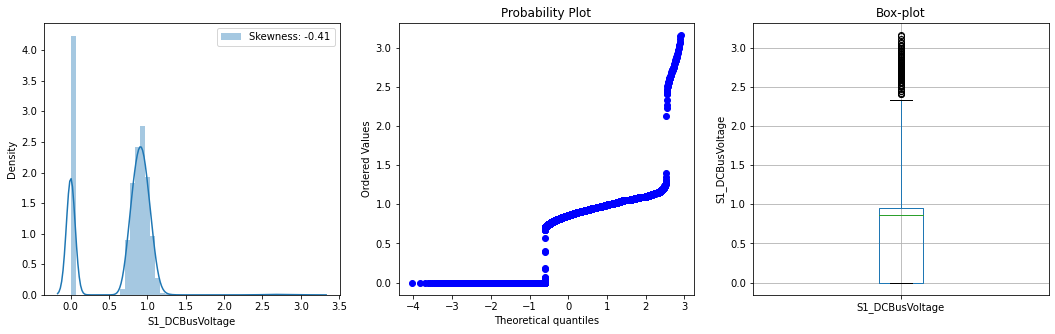

<Figure size 432x288 with 0 Axes>

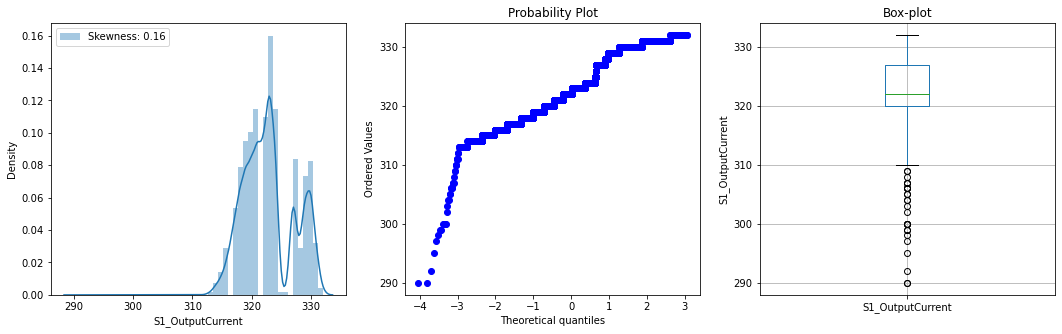

<Figure size 432x288 with 0 Axes>

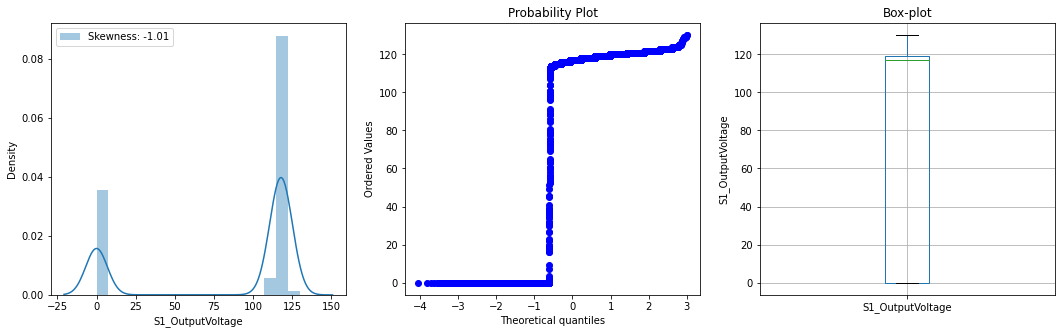

<Figure size 432x288 with 0 Axes>

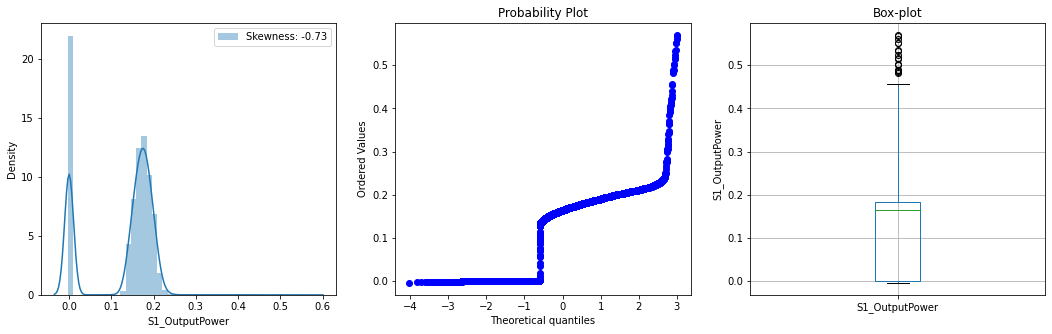

<Figure size 432x288 with 0 Axes>

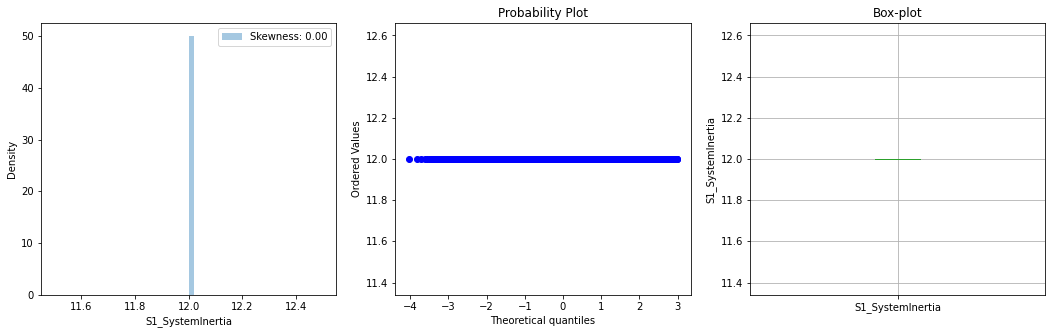

In [148]:
for var in cnc_df.columns:
    if 'S1' in var:
        diagnostic_plots(cnc_df, var)

<Figure size 432x288 with 0 Axes>

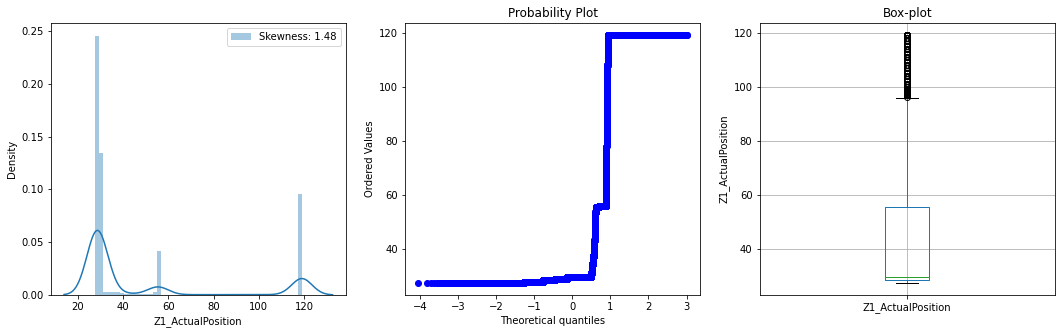

<Figure size 432x288 with 0 Axes>

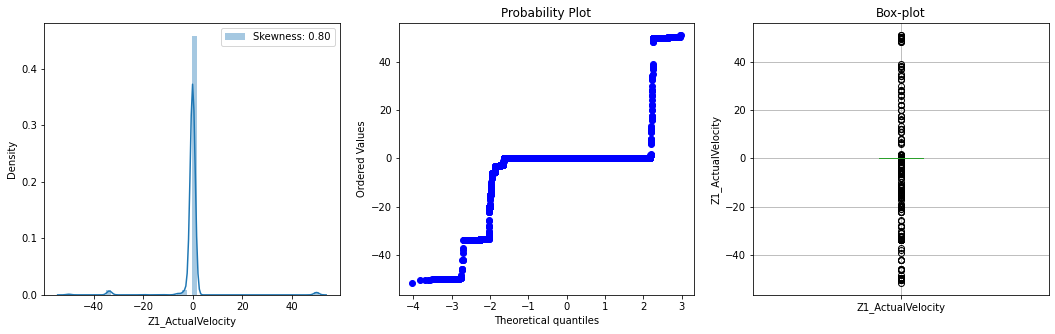

<Figure size 432x288 with 0 Axes>

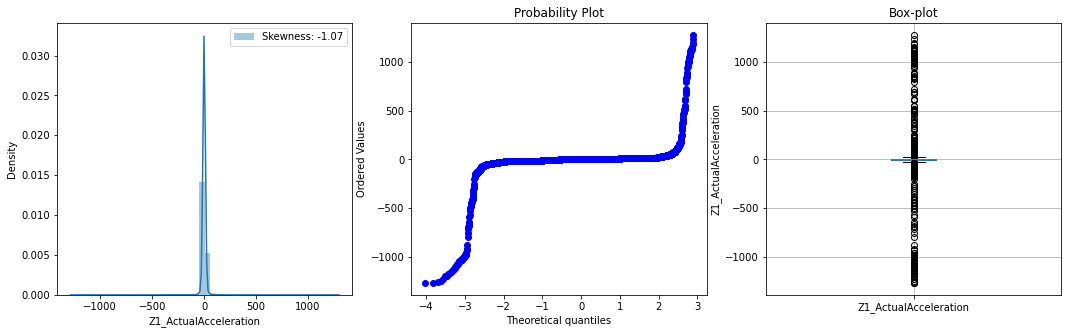

<Figure size 432x288 with 0 Axes>

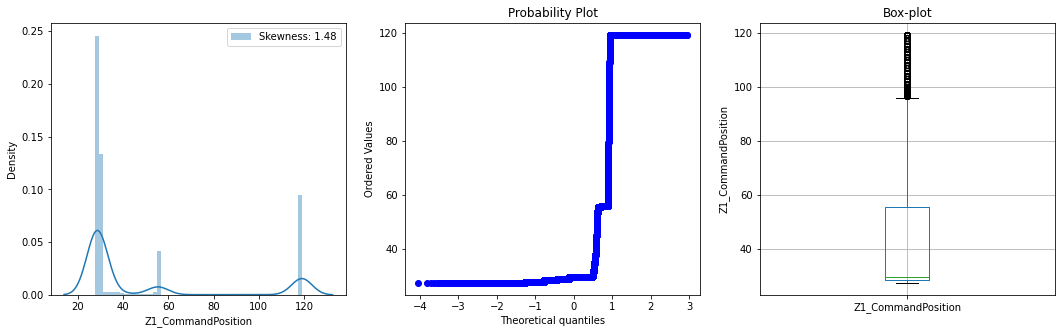

<Figure size 432x288 with 0 Axes>

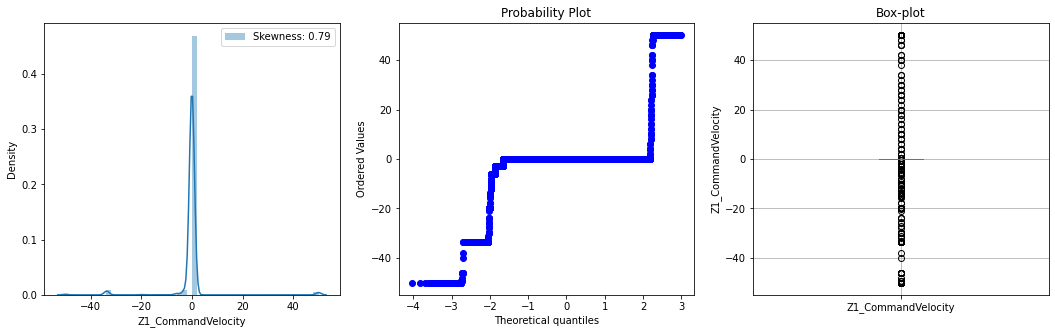

<Figure size 432x288 with 0 Axes>

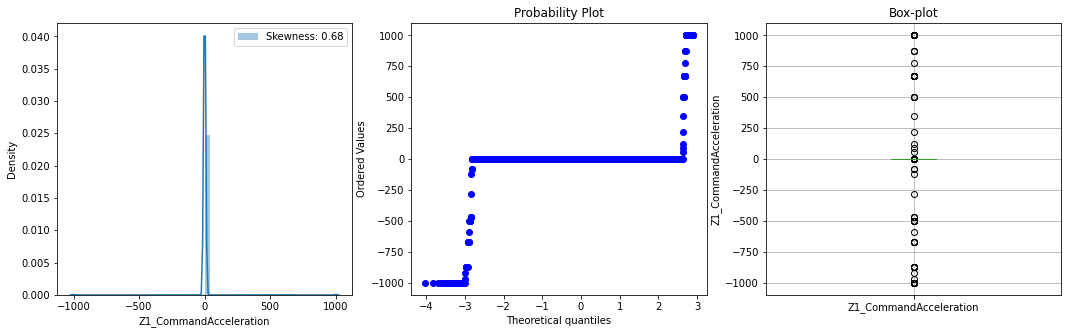

<Figure size 432x288 with 0 Axes>

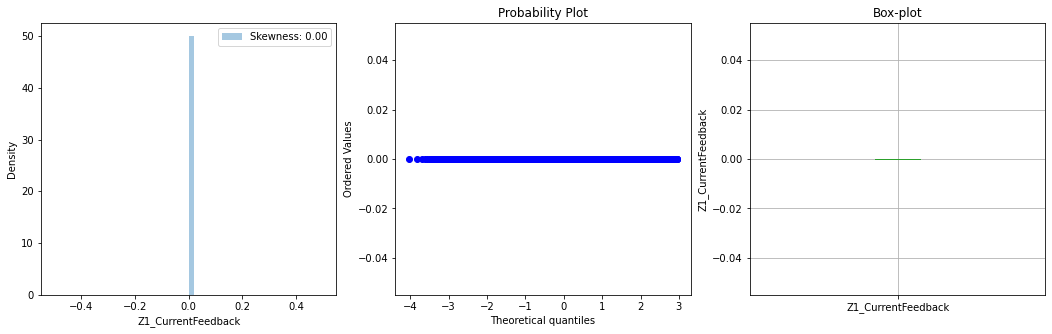

<Figure size 432x288 with 0 Axes>

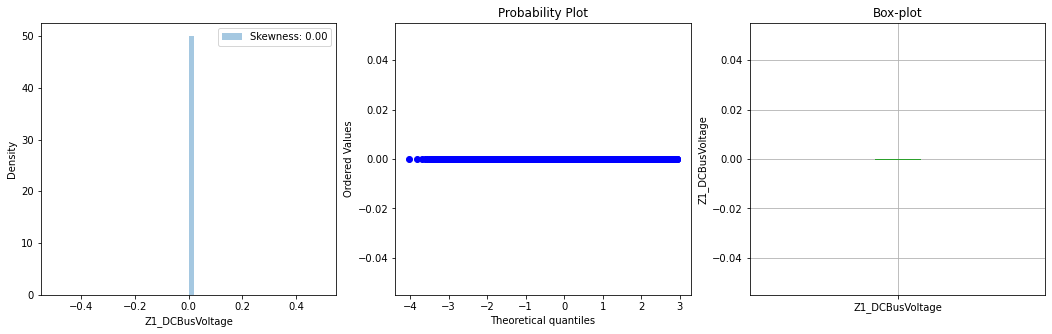

<Figure size 432x288 with 0 Axes>

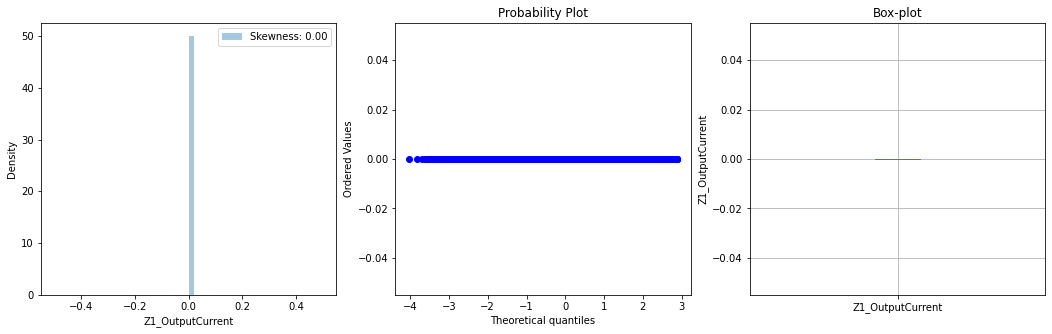

<Figure size 432x288 with 0 Axes>

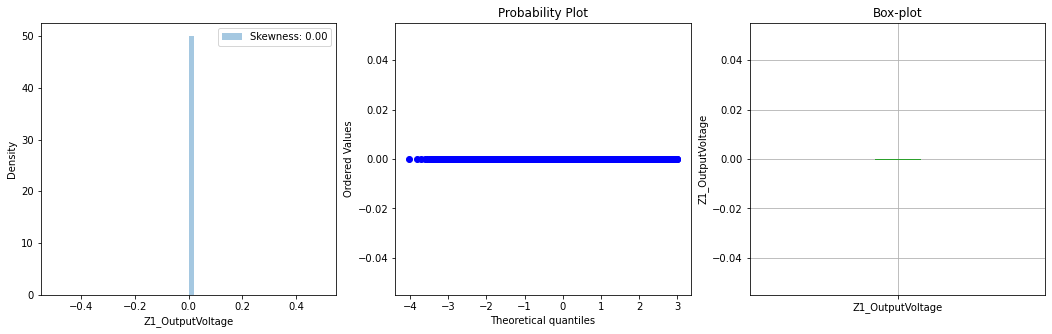

In [149]:
for var in cnc_df.columns:
    if 'Z1' in var:
        diagnostic_plots(cnc_df, var)

In [12]:
label_counts = cnc_df['label'].value_counts()
label_counts

1    13308
0    11978
Name: label, dtype: int64

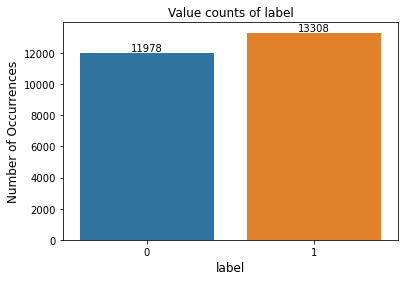

In [13]:
counts = cnc_df['label'].value_counts().rename_axis('label').reset_index(name='count')

ax = sns.barplot(x='label', y='count', data=counts)
ax.bar_label(ax.containers[0])
plt.title('Value counts of label')
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('label', fontsize = 12)
plt.show()

Now we understand that our dataset is pretty balanced.

That means training will be more easier.

It is really important to have balanced data in classification problem. 

## 4. Data Preprocessing

In [14]:
# Now we start Data Preprocessing
# Drop Machining_Process and label
X = cnc_df.drop(['label', 'Machining_Process'], axis = 1)
y = cnc_df['label']

In [15]:
# Split dataset to training set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.3
)

X_train.shape, X_test.shape

((17700, 49), (7586, 49))

### 4-1. Missing Data Imputation

In [17]:
# Function to build Pipeline with Imputer
def preprocessor_pipe(imputer):
    pipe = Pipeline([
        ('imputer', imputer)
    ])
    
    main_preprocessor = ColumnTransformer([
        ('pipe', pipe, X_train.columns)
    ])
    
    return main_preprocessor

# Function to build main pipeline to find best imputer
def clf_pipe(clf_model, main_preprocessor):
    clf = Pipeline([('preprocessor', main_preprocessor),
                    ('scaler', StandardScaler()),
                    ('clf', clf_model)])
    return clf

In [18]:
# Initialize list with imputers
imputers_list = [
    SimpleImputer(strategy = 'mean'),
    SimpleImputer(strategy = 'median'),
    KNNImputer(),
    ArbitraryNumberImputer(arbitrary_number = -999),
    EndTailImputer(imputation_method='gaussian', tail='right', fold=3),
    RandomSampleImputer()
]

In [19]:
# Iterate over a list of imputers with Grid Search to find best method for Missing Data Imputation.
imputer_names_list = []
scaler_names_list = []
train_score_list = []
test_score_list = []

for imputer in imputers_list:
    lr_model = clf_pipe(LogisticRegression(), preprocessor_pipe(imputer))

    param_grid = {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }

    grid_search_lr = GridSearchCV(lr_model, param_grid, cv = 10, n_jobs = -1, scoring = 'roc_auc')

    grid_search_lr.fit(X_train, y_train)
    
    train_score = round(grid_search_lr.score(X_train, y_train), 3)
    test_score = round(grid_search_lr.score(X_test, y_test), 3)
    
    imputer_names_list.append(type(imputer).__name__)
    scaler_names_list.append(type(grid_search_lr.best_params_['scaler']).__name__)
    train_score_list.append(train_score)
    test_score_list.append(test_score)

In [20]:
model_results_df = pd.DataFrame({
    'Imputer': imputer_names_list,
    'Scaler': scaler_names_list, 
    'Train Score': train_score_list, 
    'Test score': test_score_list
})

model_results_df

,Imputer,Scaler,Train Score,Test score
0,SimpleImputer,StandardScaler,0.651,0.639
1,SimpleImputer,StandardScaler,0.651,0.639
2,KNNImputer,StandardScaler,0.655,0.643
3,ArbitraryNumberImputer,MinMaxScaler,0.582,0.563
4,EndTailImputer,StandardScaler,0.647,0.636
5,RandomSampleImputer,StandardScaler,0.650,0.638


### 4-2. Main Pipeline Preprocessing

In [21]:
# Create a list with feature names.
features_list = X_train.columns.tolist()

In [22]:
# Function build a pipeline for data preprocessing.
def preprocessor_pipe():
    pipe = Pipeline([
        ('imputer', KNNImputer(n_neighbors = 5)),
        ('constant_features', DropConstantFeatures(tol = 0.95)),
        ('duplicate_features', DropDuplicateFeatures()),
        ('correlated_features', DropCorrelatedFeatures(threshold = 0.95, method = 'pearson')),
        ('winsorizer', Winsorizer(capping_method = 'iqr',
                                  tail = 'both',
                                  fold = 1.5))
    ])
    
    main_preprocessor = ColumnTransformer([
        ('pipe', pipe, features_list)
    ])
    
    return main_preprocessor

# Function to build main pipeline with model to find best hyperparameters for data preprocessing
def clf_pipe(clf_model, main_preprocessor):
    clf = Pipeline([('preprocessor', main_preprocessor),
                    ('scaler', StandardScaler()),
                    ('clf', clf_model)])
    return clf

In [23]:
model = clf_pipe(KNeighborsClassifier(), preprocessor_pipe())

param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'preprocessor__pipe__imputer__n_neighbors': [5, 7],
    'preprocessor__pipe__constant_features__tol': [0.95, 0.9, 0.85],
    'preprocessor__pipe__correlated_features__threshold': [0.95, 0.9, 0.85],
    'preprocessor__pipe__correlated_features__method': ['pearson', 'kendall', 'spearman']
}

grid_search_lr = GridSearchCV(model, param_grid, cv = 10, n_jobs = -1, scoring = 'roc_auc')

grid_search_lr = grid_search_lr.fit(X_train, y_train)

train_score = round(grid_search_lr.score(X_train, y_train), 3)
test_score = round(grid_search_lr.score(X_test, y_test), 3)

print("Train score: {}".format(train_score))
print("Test score: {}\n".format(test_score))

params = grid_search_lr.best_params_ 
print(params)

Train score: 0.979
Test score: 0.944

{'preprocessor__pipe__constant_features__tol': 0.95, 'preprocessor__pipe__correlated_features__method': 'pearson', 'preprocessor__pipe__correlated_features__threshold': 0.9, 'preprocessor__pipe__imputer__n_neighbors': 7, 'scaler': MinMaxScaler()}


In [24]:
pipe = Pipeline([
    ('imputer', KNNImputer(n_neighbors = 5)),
    ('constant_features', DropConstantFeatures(tol = params['preprocessor__pipe__constant_features__tol'])),
    ('duplicate_features', DropDuplicateFeatures()),
    ('correlated_features', DropCorrelatedFeatures(
        threshold = params['preprocessor__pipe__correlated_features__threshold'],
        method = params['preprocessor__pipe__correlated_features__method'])),
    ('winsorizer', Winsorizer(capping_method = 'iqr',
                              tail = 'both',
                              fold = 1.5))
])

main_preprocessor = ColumnTransformer([
    ('pipe', pipe, features_list)
])

In [25]:
main_preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('pipe',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('constant_features',
                                                  DropConstantFeatures(tol=0.95)),
                                                 ('duplicate_features',
                                                  DropDuplicateFeatures()),
                                                 ('correlated_features',
                                                  DropCorrelatedFeatures(threshold=0.9)),
                                                 ('winsorizer',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5,
                                                             tail='both'))]),
                                 ['X1_ActualPosition', 'X1_ActualVeloc...
                                  'Y1_ActualVelo

In [26]:
X_train_prep = main_preprocessor.transform(X_train)
X_test_prep = main_preprocessor.transform(X_test)

X_train_prep

array([[ 1.5200e+02, -3.0800e+00, -3.1300e+01, ...,  3.0000e+00,
         3.0000e+00,  4.0000e+00],
       [ 1.5600e+02,  3.1300e+00,  1.2500e+01, ...,  3.0000e+00,
         3.0000e+00,  2.5000e+00],
       [ 1.8750e+02, -7.5000e-02, -3.1300e+01, ...,  2.0000e+01,
         1.0500e+01,  4.0000e+00],
       ...,
       [ 1.4200e+02, -6.2500e-01,  1.2500e+01, ...,  3.0000e+00,
         3.0000e+00,  4.0000e+00],
       [ 1.6200e+02, -1.2500e-01, -7.5000e+01, ...,  3.0000e+00,
         3.0000e+00,  4.0000e+00],
       [ 1.5000e+02,  3.5625e+00, -8.7500e+01, ...,  6.0000e+00,
         6.0000e+00,  4.0000e+00]])

## 5. Model Training

In [14]:
# Function to build model pipeline.
def pipe_clf(clf_model):
    clf = Pipeline([('preprocessor', main_preprocessor),
                    ('scaler', StandardScaler()),
                    ('clf', clf_model)])
    return clf

# Function to get model prediction, evaluate the model scores and append them to lists
def score_func(grid_search_model, X_train, y_train, X_test, y_test):
    pred = grid_search_model.predict(X_test)
    train_score = grid_search_model.score(X_train, y_train)
    test_score = grid_search_model.score(X_test, y_test)
    
    print("Train roc-auc score: {0:.3g}".format(train_score))
    print("Test roc-auc score: {0:.3g}\n".format(test_score))
    print(confusion_matrix(y_test, pred), '\n')
    print("Precision_score: {0:.3g}\n".format(precision_score(y_test, pred)))
    print("Recall: {0:.3g}\n".format(recall_score(y_test, pred)))
    print("Accuracy_score: {0:.3g}\n".format(accuracy_score(y_test, pred)))
    print("F1_score: {0:.3g}\n".format(f1_score(y_test, pred)))
    print(grid_search_model.best_params_)
    print("\n")

    roc_auc_score_list.append(round(test_score, 3))
    accuracy_score_list.append(round(accuracy_score(y_test, pred), 3))
    precision_score_list.append(round(precision_score(y_test, pred), 3))
    recall_score_list.append(round(recall_score(y_test, pred), 3))
    f1_score_list.append(round(f1_score(y_test, pred), 3))
    cm_list.append(confusion_matrix(y_test, pred))

# Function to build main pipeline for training.
# Also this function perform GridSearch training. Then score results will be stored to the lists.
def model_training(model, param_grid, cv, X_train, y_train, X_test, y_test):
    clf_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    
    grid_search = GridSearchCV(clf_pipe, param_grid, cv = cv, n_jobs = -1, scoring = 'roc_auc')
    grid_search = grid_search.fit(X_train, y_train)
    
    best_params_dict[type(model).__name__] = grid_search.best_params_
    
    print("{0} evaluation results:".format(type(model).__name__))
    
    models_list.append(type(model).__name__)
    
    score_func(grid_search, X_train, y_train, X_test, y_test)

In [117]:
# create lists to save model evaluation scores.
best_params_dict = {}

models_list = []

roc_auc_score_list = []

accuracy_score_list = []

precision_score_list = []

recall_score_list = []

f1_score_list = []

cm_list = []

### Logistic Regression

In [118]:
lr_model = LogisticRegression()

In [119]:
%%timeit -r 1 -n 1

param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'clf__penalty': ['l1', 'l2', 'none', 'elasticnet'],
    'clf__dual': [True, False],
    'clf__max_iter': [100, 150, 200],
    'clf__C': [0.8, 0.9, 1.0],
    'clf__fit_intercept': [True, False],
}

model_training(lr_model, param_grid, 10, X_train_prep, y_train, X_test_prep, y_test)

LogisticRegression evaluation results:
Train roc-auc score: 0.624
Test roc-auc score: 0.605

[[1897 1692]
 [1667 2330]] 

Precision_score: 0.579

Recall: 0.583

Accuracy_score: 0.557

F1_score: 0.581

{'clf__C': 0.9, 'clf__dual': False, 'clf__fit_intercept': False, 'clf__max_iter': 100, 'clf__penalty': 'none', 'clf__solver': 'sag', 'scaler': MinMaxScaler()}


3min 44s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Random Forest Classifier

In [120]:
rf_model = RandomForestClassifier()

In [121]:
%%timeit -r 1 -n 1

param_grid = {
        'clf__criterion': ['gini', 'entropy', 'log_loss'],
        'clf__min_samples_split': [2, 3, 4],
        'clf__min_samples_leaf': [1, 2, 3],
        'clf__n_estimators': range(150, 350, 50)
}

model_training(rf_model, param_grid, 10, X_train_prep, y_train, X_test_prep, y_test)

RandomForestClassifier evaluation results:
Train roc-auc score: 1
Test roc-auc score: 1

[[3555   34]
 [  19 3978]] 

Precision_score: 0.992

Recall: 0.995

Accuracy_score: 0.993

F1_score: 0.993

{'clf__criterion': 'entropy', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3, 'clf__n_estimators': 250, 'scaler': MinMaxScaler()}


15min 1s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### KNN

In [122]:
knn_model = KNeighborsClassifier()

In [123]:
%%timeit -r 1 -n 1

param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'clf__n_neighbors': [3, 5, 7, 9],
    'clf__algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],
    'clf__leaf_size': [35, 50, 65, 80],
    'clf__weights': ['uniform', 'distance']
}

model_training(knn_model, param_grid, 10, X_train_prep, y_train, X_test_prep, y_test)

KNeighborsClassifier evaluation results:
Train roc-auc score: 1
Test roc-auc score: 0.951

[[3058  531]
 [ 459 3538]] 

Precision_score: 0.87

Recall: 0.885

Accuracy_score: 0.869

F1_score: 0.877

{'clf__algorithm': 'ball_tree', 'clf__leaf_size': 35, 'clf__n_neighbors': 7, 'clf__weights': 'distance', 'scaler': MinMaxScaler()}


10min 41s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### XGBoost Classifier

In [124]:
xgb_model = XGBClassifier()

In [125]:
%%timeit -r 1 -n 1

param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'clf__max_depth': range(2, 10, 1),
    'clf__n_estimators': range(60, 220, 40),
    'clf__learning_rate': [0.1, 0.01, 0.05]  # 0.001
}

model_training(xgb_model, param_grid, 10, X_train_prep, y_train, X_test_prep, y_test)

[13:31:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier evaluation results:
Train roc-auc score: 1
Test roc-auc score: 1

[[3572   17]
 [  21 3976]] 

Precision_score: 0.996

Recall: 0.995

Accuracy_score: 0.995

F1_score: 0.995

{'clf__learning_rate': 0.1, 'clf__max_depth': 8, 'clf__n_estimators': 180, 'scaler': MinMaxScaler()}


11min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Gradient Boosting Classifier

In [126]:
gbc_model = GradientBoostingClassifier()

In [127]:
%%timeit -r 1 -n 1

param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'clf__loss': ['log_loss', 'deviance', 'exponential'],
    'clf__learning_rate': [0.1, 0.2, 0.3],
    'clf__n_estimators': [150, 200, 250],
    'clf__criterion': ['friedman_mse', 'squared_error', 'mse']
}

model_training(gbc_model, param_grid, 10, X_train_prep, y_train, X_test_prep, y_test)

GradientBoostingClassifier evaluation results:
Train roc-auc score: 1
Test roc-auc score: 0.999

[[3565   24]
 [  29 3968]] 

Precision_score: 0.994

Recall: 0.993

Accuracy_score: 0.993

F1_score: 0.993

{'clf__criterion': 'mse', 'clf__learning_rate': 0.3, 'clf__loss': 'exponential', 'clf__n_estimators': 250, 'scaler': RobustScaler()}


19min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Deep Learning

Now we are going to try to implement deep learning to predict the target variable.

In [32]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0
True


In [33]:
# Build ANN Model using TensorFlow
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units = 512, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 256, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

In [34]:
epochs_history = model.fit(X_train_prep, y_train, validation_data = (X_test_prep, y_test), batch_size = 8, epochs = 300, verbose = 1)

Epoch 1/300
2213/2213 [==============================] - 11s 4ms/step - loss: 0.9720 - binary_accuracy: 0.5341 - val_loss: 0.6849 - val_binary_accuracy: 0.5162
Epoch 2/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.6869 - binary_accuracy: 0.5494 - val_loss: 0.6764 - val_binary_accuracy: 0.5475
Epoch 3/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.6736 - binary_accuracy: 0.5497 - val_loss: 0.6658 - val_binary_accuracy: 0.5323
Epoch 4/300
2213/2213 [==============================] - 10s 5ms/step - loss: 0.6592 - binary_accuracy: 0.5574 - val_loss: 0.6624 - val_binary_accuracy: 0.5335
Epoch 5/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.6655 - binary_accuracy: 0.5578 - val_loss: 0.6327 - val_binary_accuracy: 0.5775
Epoch 6/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.6309 - binary_accuracy: 0.5906 - val_loss: 0.6189 - val_binary_accuracy: 0.6097
Epoch 7/300
2213/2213 [=================

Epoch 52/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.3769 - binary_accuracy: 0.8021 - val_loss: 0.3732 - val_binary_accuracy: 0.8089
Epoch 53/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.3662 - binary_accuracy: 0.8057 - val_loss: 0.3853 - val_binary_accuracy: 0.7996
Epoch 54/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.3697 - binary_accuracy: 0.8068 - val_loss: 0.3865 - val_binary_accuracy: 0.7907
Epoch 55/300
2213/2213 [==============================] - 10s 5ms/step - loss: 0.3705 - binary_accuracy: 0.8055 - val_loss: 0.3742 - val_binary_accuracy: 0.8086
Epoch 56/300
2213/2213 [==============================] - 10s 5ms/step - loss: 0.3685 - binary_accuracy: 0.8089 - val_loss: 0.4111 - val_binary_accuracy: 0.7843
Epoch 57/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.3640 - binary_accuracy: 0.8083 - val_loss: 0.3871 - val_binary_accuracy: 0.8032
Epoch 58/300
2213/2213 [==========

Epoch 103/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.3125 - binary_accuracy: 0.8447 - val_loss: 0.3447 - val_binary_accuracy: 0.8289
Epoch 104/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.3147 - binary_accuracy: 0.8401 - val_loss: 0.3374 - val_binary_accuracy: 0.8381
Epoch 105/300
2213/2213 [==============================] - 12s 5ms/step - loss: 0.3086 - binary_accuracy: 0.8458 - val_loss: 0.4406 - val_binary_accuracy: 0.7614
Epoch 106/300
2213/2213 [==============================] - 12s 5ms/step - loss: 0.3068 - binary_accuracy: 0.8463 - val_loss: 0.4050 - val_binary_accuracy: 0.8211
Epoch 107/300
2213/2213 [==============================] - 12s 5ms/step - loss: 0.3021 - binary_accuracy: 0.8501 - val_loss: 0.3340 - val_binary_accuracy: 0.8278
Epoch 108/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.3088 - binary_accuracy: 0.8451 - val_loss: 0.3277 - val_binary_accuracy: 0.8309
Epoch 109/300
2213/2213 [===

2213/2213 [==============================] - 11s 5ms/step - loss: 0.2728 - binary_accuracy: 0.8730 - val_loss: 0.5965 - val_binary_accuracy: 0.7846
Epoch 204/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.2663 - binary_accuracy: 0.8701 - val_loss: 0.3449 - val_binary_accuracy: 0.8417
Epoch 205/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.2459 - binary_accuracy: 0.8782 - val_loss: 0.3355 - val_binary_accuracy: 0.8430
Epoch 206/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.2475 - binary_accuracy: 0.8768 - val_loss: 0.3775 - val_binary_accuracy: 0.8441
Epoch 207/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.2390 - binary_accuracy: 0.8805 - val_loss: 0.4048 - val_binary_accuracy: 0.8576
Epoch 208/300
2213/2213 [==============================] - 11s 5ms/step - loss: 0.2472 - binary_accuracy: 0.8763 - val_loss: 0.3401 - val_binary_accuracy: 0.8580
Epoch 209/300
2213/2213 [=================

In [130]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               15872     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 188,417
Trainable params: 188,417
Non-trainable params: 0
_________________________________________________________________


In [131]:
model.save('cnc_model_final.h5')

In [134]:
# Function to plot training and validation loss, training and validation accuracy during training.
def show_final_history(epochs_history):
    fig, ax = plt.subplots(1, 2, figsize = (18, 5))

    ax[0].set_title('Loss')
    ax[0].plot(epochs_history.epoch, epochs_history.history['loss'], label = 'Train loss')
    ax[0].plot(epochs_history.epoch, epochs_history.history['val_loss'], label = 'Validation loss')

    ax[1].set_title('Accuracy')
    ax[1].plot(epochs_history.epoch, epochs_history.history['binary_accuracy'], label = 'Train acc')
    ax[1].plot(epochs_history.epoch, epochs_history.history['val_binary_accuracy'], label = 'Validation acc')
    ax[0].legend()
    ax[1].legend()

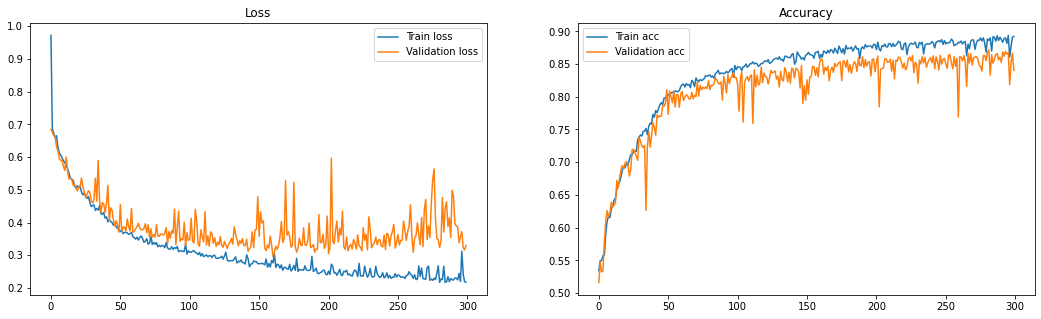

In [135]:
show_final_history(epochs_history)

In [136]:
# Store model's name to list
models_list.append('Deep Learning(ANN)')

In [137]:
# Predict the target using ANN Model
pred = model.predict(X_test_prep, verbose = 0)
pred = np.where(pred < 0.5, 0, 1)

print(confusion_matrix(y_test, pred), '\n')
print("roc_auc_score: {0:.3g}\n".format(roc_auc_score(y_test, pred)))
print("Precision_score: {0:.3g}\n".format(precision_score(y_test, pred)))
print("Recall: {0:.3g}\n".format(recall_score(y_test, pred)))
print("Accuracy_score: {0:.3g}\n".format(accuracy_score(y_test, pred)))
print("F1_score: {0:.3g}".format(f1_score(y_test, pred)))

# Store the metrics score to list
roc_auc_score_list.append(round(roc_auc_score(y_test, pred), 3))
accuracy_score_list.append(round(accuracy_score(y_test, pred), 3))
precision_score_list.append(round(precision_score(y_test, pred), 3))
recall_score_list.append(round(recall_score(y_test, pred), 3))
f1_score_list.append(round(f1_score(y_test, pred), 3))
cm_list.append(confusion_matrix(y_test, pred))

[[3366  223]
 [ 987 3010]] 

roc_auc_score: 0.845

Precision_score: 0.931

Recall: 0.753

Accuracy_score: 0.84

F1_score: 0.833


## 6. Evaluation Results

In [138]:
# Function to plot the score results sorting by specified metric
def results_plot(metric):
    plt.figure(figsize=(12, 5))
    sns.barplot(data = model_results_df.sort_values(by = metric, ascending = False), 
            x = metric, y = 'Model')
    plt.title(metric, fontsize = 12)
    plt.xlabel(metric)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.show()

# Plot the confusion matrix of model evaluation results
def plot_cm(model, cm):
    f, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm, annot = True, linewidths=0.5, linecolor="red", fmt = ".0f", ax = ax)
    plt.title(model)
    plt.xlabel("y_pred")
    plt.ylabel("y_test")
    plt.show()

In [139]:
model_results_df = pd.DataFrame({
    'Model': models_list,
    'roc_auc_score': roc_auc_score_list, 
    'accuracy_score': accuracy_score_list, 
    'precision_score': precision_score_list,
    'recall_score': recall_score_list,
    'f1_score': f1_score_list
})

In [140]:
model_results_df

,Model,roc_auc_score,accuracy_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.605,0.557,0.579,0.583,0.581
1,RandomForestClassifier,1.000,0.993,0.992,0.995,0.993
2,KNeighborsClassifier,0.951,0.869,0.870,0.885,0.877
3,XGBClassifier,1.000,0.995,0.996,0.995,0.995
4,GradientBoostingClassifier,0.999,0.993,0.994,0.993,0.993
5,Deep Learning(ANN),0.845,0.840,0.931,0.753,0.833


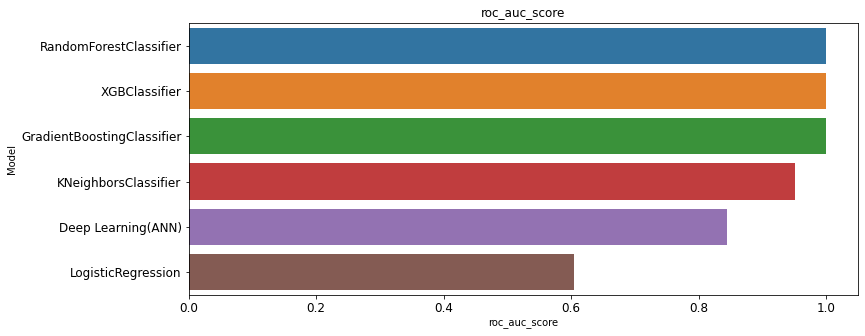

In [141]:
results_plot('roc_auc_score')

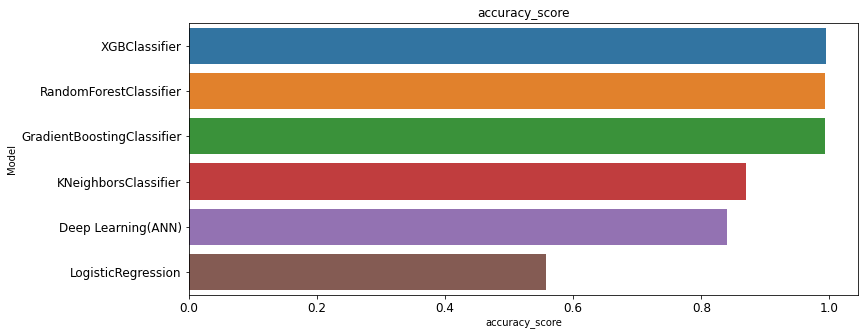

In [142]:
results_plot('accuracy_score')

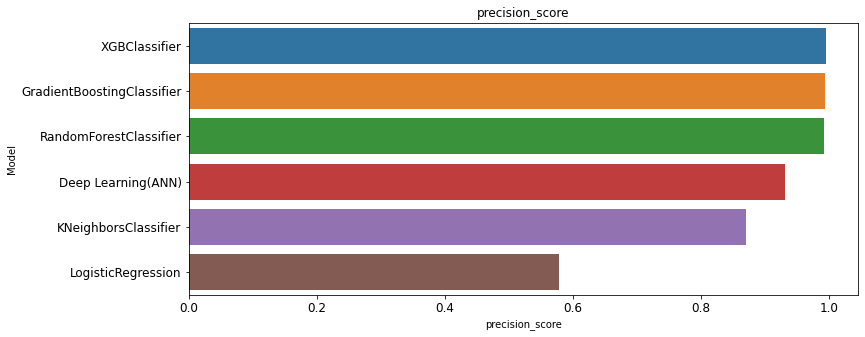

In [143]:
results_plot('precision_score')

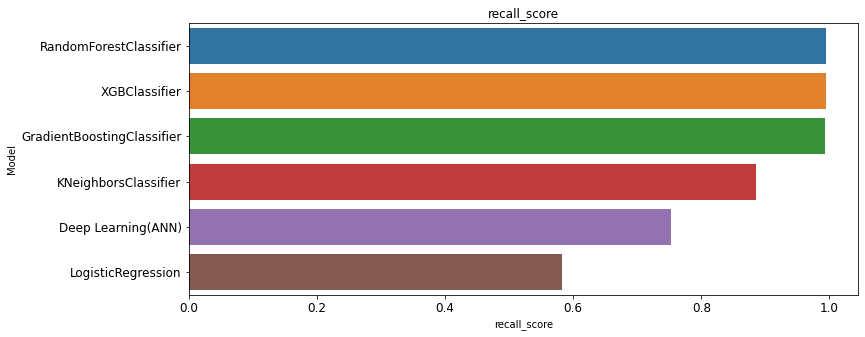

In [144]:
results_plot('recall_score')

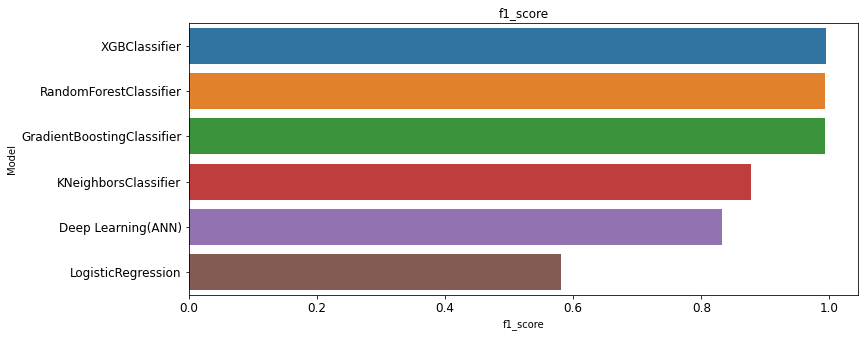

In [145]:
results_plot('f1_score')

In [146]:
models_list = model_results_df['Model'].tolist()

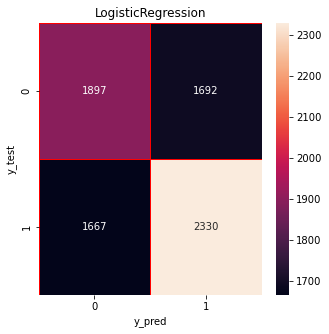

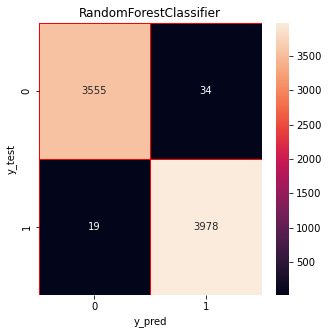

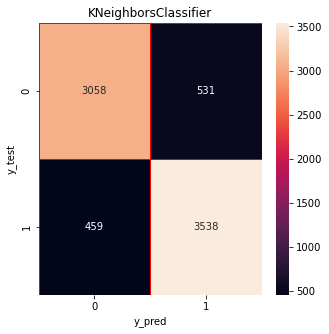

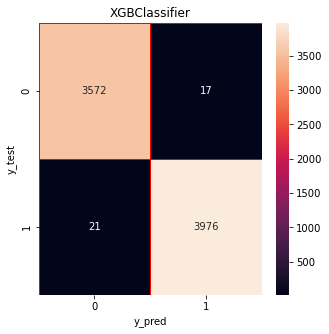

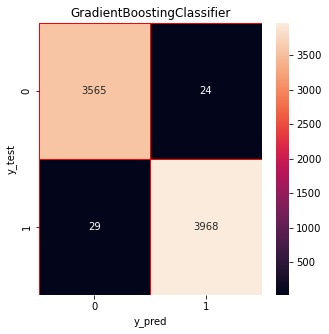

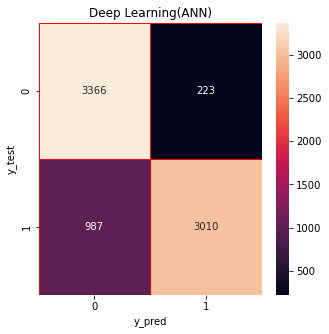

In [147]:
for model, cm in zip(models_list, cm_list):
    plot_cm(model, cm)

## Conclusion

As our dataset is pretty balanced, although with some portion of missing data we have used various types of imputation methods. As the results showed all imputation methods worked out good except for ArbitraryNumberImputer

According to the evaluation results, XGBoost, Random Forest and Gradient Boosting algorithms have almost the same score.

But if you check the confusion matrix, XGBoost has a little bit better score(especially, in case of Type-II error)

Thats for this project we choose XGBoost as a best algorithm.